# A. JCC2 Data Processor

In [1]:
"""
JCC2 Data Processor - Unified processor for multiple JCC2 data formats

Supports:
- JCC2 User Questionnaire format (effectiveness ratings, frequencies)
- JCC2 Data Collection and Interview format (task performance, datatables)
"""

import pandas as pd
import numpy as np
import logging
from pathlib import Path
from typing import Dict, List, Optional, Any, Union
from dataclasses import dataclass, field as dataclass_field
from datetime import datetime
import json
from collections import defaultdict
from abc import ABC, abstractmethod
from enum import Enum
import matplotlib.pyplot as plt


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("py4j")
logger.setLevel(logging.ERROR)


class DataFormat(Enum):
    """Enum for different JCC2 data formats"""
    USER_QUESTIONNAIRE = "user_questionnaire"
    DATA_COLLECTION = "data_collection"
    UNKNOWN = "unknown"


@dataclass
class FieldSchema:
    """Represents the schema definition for a single field"""
    name: str
    section: Optional[str]
    field_id: Optional[str]
    field_type: str
    required: bool = False
    options: List[str] = dataclass_field(default_factory=list)
    depends_on: Optional[str] = None
    min_value: Optional[float] = None
    max_value: Optional[float] = None
    multiple: bool = False
    # New fields for datatable support
    columns: Optional[int] = None
    column_types: Dict[str, str] = dataclass_field(default_factory=dict)
    min_rows: Optional[int] = None
    max_rows: Optional[int] = None
    
    @classmethod
    def parse(cls, column_name: str, schema_string: str) -> 'FieldSchema':
        """Parse schema string into FieldSchema object"""
        # Parse column name for section and field_id
        section = None
        field_id = column_name
        
        if '.' in column_name:
            parts = column_name.split('.', 1)
            section = parts[0]
            field_id = parts[1]
        
        # Parse schema string
        parts = schema_string.split('|')
        field_type = parts[0] if parts else 'text'
        
        schema_obj = cls(
            name=column_name,
            section=section,
            field_id=field_id,
            field_type=field_type
        )
        
        # Parse additional attributes
        for part in parts[1:]:
            if part == 'required':
                schema_obj.required = True
            elif part == 'optional':
                schema_obj.required = False
            elif part == 'multiple':
                schema_obj.multiple = True
            elif part.startswith('options:'):
                options_str = part[8:]
                schema_obj.options = [opt.strip() for opt in options_str.split(',')]
            elif part.startswith('depends_on:'):
                schema_obj.depends_on = part[11:]
            elif part.startswith('min:'):
                schema_obj.min_value = float(part[4:])
            elif part.startswith('max:'):
                schema_obj.max_value = float(part[4:])
            elif part.startswith('columns:'):
                schema_obj.columns = int(part[8:])
            elif part.startswith('column_types:'):
                # Parse column types for datatable
                col_types_str = part[13:]
                for col_def in col_types_str.split('|'):
                    if ':' in col_def:
                        col_name, col_type = col_def.split(':', 1)
                        schema_obj.column_types[col_name] = col_type
            elif part.startswith('minRows:'):
                schema_obj.min_rows = int(part[8:])
            elif part.startswith('maxRows:'):
                schema_obj.max_rows = int(part[8:])
        
        return schema_obj


class BaseJCC2Processor(ABC):
    """Base processor for JCC2 data formats"""
    
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        self.df: Optional[pd.DataFrame] = None
        self.schema: Dict[str, FieldSchema] = {}
        self.sections: Dict[str, List[str]] = defaultdict(list)
        self.system_columns: List[str] = []
        self.validation_errors: List[Dict[str, Any]] = []
        self.format_type: DataFormat = DataFormat.UNKNOWN
        self.datatable_fields: Dict[str, Any] = {}
        
    def load_data(self) -> pd.DataFrame:
        """Load CSV data and parse schema"""
        logger.info(f"Loading data from {self.csv_path}")
        
        # Read the CSV file
        raw_df = pd.read_csv(self.csv_path, low_memory=False)
        
        # Extract header and schema rows
        columns = raw_df.columns.tolist()
        schema_row = raw_df.iloc[0].tolist() if len(raw_df) > 0 else []
        
        # Parse schema
        logger.info("Parsing field schemas")
        for col, schema_str in zip(columns, schema_row):
            try:
                field_schema = FieldSchema.parse(col, str(schema_str))
                self.schema[col] = field_schema
                
                # Organize by sections
                if field_schema.section:
                    self.sections[field_schema.section].append(col)
                else:
                    self.system_columns.append(col)
                    
            except Exception as e:
                logger.error(f"Error parsing schema for column '{col}': {e}")
        
        # Extract actual data (skip schema row)
        self.df = raw_df.iloc[1:].copy()
        
        # Convert data types based on schema
        self._convert_data_types()
        
        logger.info(f"Loaded {len(self.df)} data rows with {len(columns)} columns")
        logger.info(f"Found {len(self.sections)} sections and {len(self.system_columns)} system columns")
        
        return self.df
    
    def _convert_data_types(self):
        """Convert column data types based on schema definitions"""
        for col_name, field_schema in self.schema.items():
            if col_name not in self.df.columns:
                continue
                
            try:
                if field_schema.field_type == 'datetime':
                    self.df[col_name] = pd.to_datetime(self.df[col_name], errors='coerce')
                elif field_schema.field_type == 'date':
                    self.df[col_name] = pd.to_datetime(self.df[col_name], errors='coerce').dt.date
                elif field_schema.field_type == 'number':
                    self.df[col_name] = pd.to_numeric(self.df[col_name], errors='coerce')
                elif field_schema.field_type == 'identifier':
                    # Keep as string
                    self.df[col_name] = self.df[col_name].astype(str)
                elif field_schema.field_type == 'checkbox' and field_schema.multiple:
                    # Split multiple values
                    self.df[col_name] = self.df[col_name].apply(
                        lambda x: [s.strip() for s in x.split(';')] if pd.notna(x) and x else []
                    )
                elif field_schema.field_type == 'datatable':
                    # Parse JSON datatable content
                    self.df[col_name] = self.df[col_name].apply(self._parse_datatable)
                    self.datatable_fields[col_name] = field_schema
                elif field_schema.field_type == 'unknown':
                    # Treat unknown fields as text
                    logger.warning(f"Unknown field type for column '{col_name}', treating as text")
                    self.df[col_name] = self.df[col_name].astype(str, errors='ignore')
            except Exception as e:
                logger.error(f"Error converting type for column '{col_name}': {e}")
    
    def validate_data(self) -> List[Dict[str, Any]]:
        """Validate data against schema constraints"""
        logger.info("Validating data against schema")
        self.validation_errors = []
        for idx, row in self.df.iterrows():
            for col_name, field_schema in self.schema.items():
                if col_name not in self.df.columns:
                    continue
                value = row[col_name]
#                 print(f"Validating value: [{row[8]}][{col_name}] = {value}")

                # Check required fields
                if field_schema.required:
                    is_empty = False
                    if isinstance(value, list):
                        # Handle cases where value is a list
                        if not value:  # Empty list like []
                            is_empty = True
                        elif all(item == '' or item is None for item in value):  # List contains only empty strings or None
                            is_empty = True
                    else:
                        # Handle cases where value is not a list (scalar)
                        if pd.isna(value):  # pd.isna() is appropriate for scalars like NaN, None, etc.
                            is_empty = True
                    if is_empty:
                        self.validation_errors.append({
                            'row': idx,
                            'column': col_name,
                            'error': 'Required field is empty',
                            'value': value
                        })

                # Check options for radio/select fields
                if field_schema.options:
                    if isinstance(value, list):
                        # If it's a list, check if ANY element is not NaN
                        if not all(pd.isna(item) for item in value):  # Check if at least ONE element is NOT NaN
                            if field_schema.field_type in ['radio', 'select']:
                                for item in value:
                                    if str(item) not in field_schema.options and not pd.isna(item):
                                        self.validation_errors.append({
                                            'row': idx,
                                            'column': col_name,
                                            'error': f'Invalid option: {item}',
                                            'valid_options': field_schema.options
                                        })
                            elif field_schema.field_type == 'checkbox' and field_schema.multiple:
                                invalid_opts = [v for v in value if v not in field_schema.options]
                                if invalid_opts:
                                    self.validation_errors.append({
                                        'row': idx,
                                        'column': col_name,
                                        'error': f'Invalid options: {invalid_opts}',
                                        'valid_options': field_schema.options
                                    })


                    elif pd.notna(value):  # For scalar values
                        if field_schema.field_type in ['radio', 'select']:
                            if str(value) not in field_schema.options:
                                self.validation_errors.append({
                                    'row': idx,
                                    'column': col_name,
                                    'error': f'Invalid option: {value}',
                                    'valid_options': field_schema.options
                                })
                        elif field_schema.field_type == 'checkbox' and field_schema.multiple:
                            # This case shouldn't happen (scalar value with multiple=True), but handle it gracefully
                            print(f"Warning: Scalar value '{value}' found for checkbox field with multiple=True.  This is unexpected.")
                            if value not in field_schema.options:
                                self.validation_errors.append({
                                    'row': idx,
                                    'column': col_name,
                                    'error': f'Invalid option: {value}',
                                    'valid_options': field_schema.options
                                })


                # Check numeric ranges
                if field_schema.field_type == 'number' and pd.notna(value):
                    if field_schema.min_value is not None and value < field_schema.min_value:
                        self.validation_errors.append({
                            'row': idx,
                            'column': col_name,
                            'error': f'Value {value} below minimum {field_schema.min_value}'
                        })
                    if field_schema.max_value is not None and value > field_schema.max_value:
                        self.validation_errors.append({
                            'row': idx,
                            'column': col_name,
                            'error': f'Value {value} above maximum {field_schema.max_value}'
                        })
        logger.info(f"Validation complete: found {len(self.validation_errors)} errors")
        return self.validation_errors
    
    def get_section_summary(self, section_name: str) -> Dict[str, Any]:
        """Generate statistical summary for a specific section"""
        if section_name not in self.sections:
            logger.warning(f"Section '{section_name}' not found")
            return {}
        
        section_cols = self.sections[section_name]
        summary = {
            'section': section_name,
            'total_fields': len(section_cols),
            'field_summaries': {}
        }
        
        for col in section_cols:
            field_schema = self.schema[col]
            col_summary = {
                'field_type': field_schema.field_type,
                'non_null_count': self.df[col].notna().sum(),
                'null_count': self.df[col].isna().sum(),
                'completion_rate': self.df[col].notna().mean()
            }
            
            # Add type-specific summaries
            if field_schema.field_type in ['radio', 'select']:
                value_counts = self.df[col].value_counts()
                col_summary['value_distribution'] = value_counts.to_dict()
                col_summary['most_common'] = value_counts.index[0] if len(value_counts) > 0 else None
                
            elif field_schema.field_type == 'checkbox' and field_schema.multiple:
                # Flatten lists and count occurrences
                all_values = []
                for val_list in self.df[col].dropna():
                    if isinstance(val_list, list):
                        all_values.extend(val_list)
                value_counts = pd.Series(all_values).value_counts()
                col_summary['value_distribution'] = value_counts.to_dict()
                
            elif field_schema.field_type == 'number':
                col_summary['mean'] = self.df[col].mean()
                col_summary['std'] = self.df[col].std()
                col_summary['min'] = self.df[col].min()
                col_summary['max'] = self.df[col].max()
                col_summary['median'] = self.df[col].median()
            
            summary['field_summaries'][col] = col_summary
        
        return summary
    
    def get_all_sections_summary(self) -> Dict[str, Dict[str, Any]]:
        """Generate summaries for all sections"""
        all_summaries = {}
        for section_name in self.sections:
            all_summaries[section_name] = self.get_section_summary(section_name)
        return all_summaries
    
    def analyze_application_patterns(self) -> Dict[str, Any]:
        """Analyze response patterns across different applications"""
        # Find all application-related columns
        app_patterns = defaultdict(dict)
        
        # Common application names found in the data
        applications = [
            'jcc2cyberops', 'jcc2readiness', 'a2it', 'cad', 'codex', 
            'crucible', 'cyber9line', 'dispatch', 'madss', 'rally', 
            'redmap', 'sigact', 'threathub', 'triage', 'unity'
        ]
        
        for app in applications:
            app_cols = [col for col in self.df.columns if app in col.lower()]
            
            if not app_cols:
                continue
                
            app_patterns[app] = {
                'total_fields': len(app_cols),
                'sections': defaultdict(list)
            }
            
            # Group by section
            for col in app_cols:
                if col in self.schema:
                    section = self.schema[col].section
                    if section:
                        app_patterns[app]['sections'][section].append(col)
            
            # Calculate overall engagement
            non_null_counts = []
            for col in app_cols:
                if col in self.df.columns:
                    non_null_counts.append(self.df[col].notna().sum())
            
            if non_null_counts:
                app_patterns[app]['avg_responses'] = np.mean(non_null_counts)
                app_patterns[app]['total_responses'] = sum(non_null_counts)
        
        return dict(app_patterns)
    
    def _parse_datatable(self, value: Any) -> Optional[Dict[str, Any]]:
        """Parse datatable JSON content"""
        if pd.isna(value) or value == 'null' or not value:
            return None
        
        try:
            if isinstance(value, str):
                return json.loads(value)
            return value
        except json.JSONDecodeError:
            logger.error(f"Failed to parse datatable JSON: {value[:100]}...")
            return None
    
    @abstractmethod
    def get_format_specific_summary(self) -> Dict[str, Any]:
        """Get format-specific summary data"""
        pass
    
    @abstractmethod
    def prepare_format_specific_visualizations(self) -> Dict[str, Any]:
        """Prepare format-specific visualization data"""
        pass
    
    def prepare_visualization_data(self) -> Dict[str, pd.DataFrame]:
        """Prepare data structures optimized for visualization"""
        viz_data = {}
        
        # Prepare data for effectiveness heatmaps
        effectiveness_cols = [col for col in self.df.columns 
                            if 'effectiveness' in col or 'effective' in col.lower()]
        
        if effectiveness_cols:
            # Extract effectiveness ratings
            effectiveness_data = self.df[effectiveness_cols].copy()
            
            # Map text ratings to numeric values
            rating_map = {
                'Completely Ineffective': 1,
                'Moderately Ineffective': 2,
                'Slightly Ineffective': 3,
                'Slightly Effective': 4,
                'Moderately Effective': 5,
                'Completely Effective': 6,
                'Not Applicable': np.nan
            }
            
            for col in effectiveness_cols:
                effectiveness_data[col] = effectiveness_data[col].map(rating_map)
            
            viz_data['effectiveness_heatmap'] = effectiveness_data
        
        # Prepare data for frequency bar charts
        frequency_cols = [col for col in self.df.columns if 'frequency' in col.lower()]
        if frequency_cols:
            viz_data['frequency_data'] = self.df[frequency_cols].copy()
        
        # Prepare application usage summary
        app_usage = []
        for app, pattern in self.analyze_application_patterns().items():
            app_usage.append({
                'application': app,
                'total_fields': pattern['total_fields'],
                'avg_responses': pattern.get('avg_responses', 0),
                'total_responses': pattern.get('total_responses', 0)
            })
        
        viz_data['application_usage'] = pd.DataFrame(app_usage)
        
        return viz_data
    
    def export_summary(self, output_path: Optional[str] = None) -> Dict[str, Any]:
        """Export comprehensive summary of the data"""
        summary = {
            'metadata': {
                'source_file': str(self.csv_path),
                'processed_at': datetime.now().isoformat(),
                'total_rows': len(self.df),
                'total_columns': len(self.df.columns),
                'total_sections': len(self.sections),
                'validation_errors': len(self.validation_errors)
            },
            'sections': self.get_all_sections_summary(),
            'application_patterns': self.analyze_application_patterns(),
            'validation_errors': self.validation_errors[:10],  # First 10 errors
            'format_type': self.format_type.value,
            'format_specific': self.get_format_specific_summary()
        }
        
        if output_path:
            with open(output_path, 'w') as f:
                json.dump(summary, f, indent=2, default=str)
            logger.info(f"Summary exported to {output_path}")
        
        return summary


class UserQuestionnaireProcessor(BaseJCC2Processor):
    """Processor for JCC2 User Questionnaire format"""
    
    def __init__(self, csv_path: str):
        super().__init__(csv_path)
        self.format_type = DataFormat.USER_QUESTIONNAIRE
    
    def get_format_specific_summary(self) -> Dict[str, Any]:
        """Get questionnaire-specific summary"""
        summary = {
            'effectiveness_ratings': {},
            'frequency_distributions': {},
            'section_completion_rates': {}
        }
        
        # Analyze effectiveness ratings
        effectiveness_cols = [col for col in self.df.columns 
                            if 'effectiveness' in col or 'effective' in col.lower()]
        
        for col in effectiveness_cols:
            if col in self.df.columns:
                value_counts = self.df[col].value_counts()
                summary['effectiveness_ratings'][col] = value_counts.to_dict()
        
        # Analyze frequency distributions
        frequency_cols = [col for col in self.df.columns if 'frequency' in col.lower()]
        for col in frequency_cols:
            if col in self.df.columns:
                value_counts = self.df[col].value_counts()
                summary['frequency_distributions'][col] = value_counts.to_dict()
        
        # Calculate section completion rates
        for section_name, columns in self.sections.items():
            non_null_counts = [self.df[col].notna().sum() for col in columns if col in self.df.columns]
            if non_null_counts:
                avg_completion = np.mean(non_null_counts) / len(self.df) if len(self.df) > 0 else 0
                summary['section_completion_rates'][section_name] = avg_completion
        
        return summary
    
    def prepare_format_specific_visualizations(self) -> Dict[str, Any]:
        """Prepare questionnaire-specific visualizations"""
        viz_data = {}
        
        # Effectiveness heatmap data
        effectiveness_cols = [col for col in self.df.columns 
                            if 'effectiveness' in col or 'effective' in col.lower()]
        
        if effectiveness_cols:
            effectiveness_data = self.df[effectiveness_cols].copy()
            
            # Map text ratings to numeric values
            rating_map = {
                'Completely Ineffective': 1,
                'Moderately Ineffective': 2,
                'Slightly Ineffective': 3,
                'Slightly Effective': 4,
                'Moderately Effective': 5,
                'Completely Effective': 6,
                'Not Applicable': np.nan
            }
            
            for col in effectiveness_cols:
                effectiveness_data[col] = effectiveness_data[col].map(rating_map)
            
            viz_data['effectiveness_heatmap'] = effectiveness_data
        
        # Frequency bar charts data
        frequency_cols = [col for col in self.df.columns if 'frequency' in col.lower()]
        if frequency_cols:
            viz_data['frequency_data'] = self.df[frequency_cols].copy()
        
        return viz_data


class DataCollectionProcessor(BaseJCC2Processor):
    """Processor for JCC2 Data Collection and Interview format"""
    
    def __init__(self, csv_path: str):
        super().__init__(csv_path)
        self.format_type = DataFormat.DATA_COLLECTION
        self.task_performance_data: Dict[str, pd.DataFrame] = {}
    
    def get_format_specific_summary(self) -> Dict[str, Any]:
        """Get data collection-specific summary"""
        summary = {
            'task_performance_metrics': {},
            'workaround_analysis': {},
            'problem_occurrence_rates': {},
            'datatable_summaries': {}
        }
        
        # Analyze task performance
        for section_name, columns in self.sections.items():
            if section_name.startswith(('mop', 'mos')):
                section_metrics = self._analyze_task_section(section_name, columns)
                if section_metrics:
                    summary['task_performance_metrics'][section_name] = section_metrics
        
        # Analyze workarounds
        workaround_cols = [col for col in self.df.columns if 'workaround' in col.lower()]
        for col in workaround_cols:
            if col in self.df.columns and 'details' not in col:
                value_counts = self.df[col].value_counts()
                summary['workaround_analysis'][col] = {
                    'yes_count': int(value_counts.get('Yes', 0)),
                    'no_count': int(value_counts.get('No', 0)),
                    'na_count': int(value_counts.get('N/A', 0))
                }
        
        # Analyze problem occurrences
        problem_cols = [col for col in self.df.columns if 'problem_occurrence' in col.lower()]
        for col in problem_cols:
            if col in self.df.columns and 'details' not in col:
                value_counts = self.df[col].value_counts()
                summary['problem_occurrence_rates'][col] = value_counts.to_dict()
        
        # Summarize datatable fields
        for field_name, field_schema in self.datatable_fields.items():
            if field_name in self.df.columns:
                dt_summary = self._summarize_datatable_field(field_name)
                if dt_summary:
                    summary['datatable_summaries'][field_name] = dt_summary
        
        return summary
    
    def _analyze_task_section(self, section_name: str, columns: List[str]) -> Dict[str, Any]:
        """Analyze a task performance section"""
        metrics = {}
        
        # Look for performance columns
        perf_col = f"{section_name}.task_performance"
        if perf_col in columns and perf_col in self.df.columns:
            value_counts = self.df[perf_col].value_counts()
            metrics['performance_distribution'] = value_counts.to_dict()
            
            # Calculate success rate
            yes_count = value_counts.get('Yes', 0)
            total_valid = sum(value_counts.get(val, 0) for val in ['Yes', 'No'])
            if total_valid > 0:
                metrics['success_rate'] = yes_count / total_valid
        
        # Look for outcome columns
        outcome_col = f"{section_name}.task_outcome"
        if outcome_col in columns and outcome_col in self.df.columns:
            value_counts = self.df[outcome_col].value_counts()
            metrics['outcome_distribution'] = value_counts.to_dict()
        
        return metrics
    
    def _summarize_datatable_field(self, field_name: str) -> Dict[str, Any]:
        """Summarize a datatable field"""
        summary = {
            'total_entries': 0,
            'avg_rows_per_entry': 0,
            'column_summaries': {}
        }
        
        valid_datatables = []
        for dt in self.df[field_name].dropna():
            if isinstance(dt, dict) and 'rows' in dt:
                valid_datatables.append(dt)
                summary['total_entries'] += 1
        
        if valid_datatables:
            row_counts = [len(dt.get('rows', [])) for dt in valid_datatables]
            summary['avg_rows_per_entry'] = np.mean(row_counts)
            
            # Analyze columns if present
            if valid_datatables[0].get('columns'):
                for col_def in valid_datatables[0]['columns']:
                    col_id = col_def.get('id', '')
                    col_type = col_def.get('type', '')
                    summary['column_summaries'][col_id] = {
                        'type': col_type,
                        'label': col_def.get('label', '')
                    }
        
        return summary
    
    def prepare_format_specific_visualizations(self) -> Dict[str, Any]:
        """Prepare data collection-specific visualizations"""
        viz_data = {}
        
        # Task performance success rates
        performance_data = []
        for section_name, columns in self.sections.items():
            if section_name.startswith(('mop', 'mos')):
                perf_col = f"{section_name}.task_performance"
                if perf_col in self.df.columns:
                    value_counts = self.df[perf_col].value_counts()
                    yes_count = value_counts.get('Yes', 0)
                    total_valid = sum(value_counts.get(val, 0) for val in ['Yes', 'No'])
                    if total_valid > 0:
                        performance_data.append({
                            'task': section_name,
                            'success_rate': yes_count / total_valid,
                            'total_attempts': total_valid
                        })
        
        if performance_data:
            viz_data['task_performance'] = pd.DataFrame(performance_data)
        
        # Workaround frequency
        workaround_data = []
        for col in self.df.columns:
            if 'workaround' in col.lower() and 'details' not in col:
                value_counts = self.df[col].value_counts()
                if 'Yes' in value_counts:
                    workaround_data.append({
                        'field': col,
                        'workaround_count': int(value_counts['Yes']),
                        'total_responses': int(value_counts.sum())
                    })
        
        if workaround_data:
            viz_data['workaround_frequency'] = pd.DataFrame(workaround_data)
        
        return viz_data
    
    def analyze_performance_patterns(self) -> Dict[str, Any]:
        """Analyze performance patterns across tasks"""
        patterns = {
            'task_success_rates': {},
            'workaround_correlations': {},
            'problem_impact_analysis': {}
        }
        
        # Calculate success rates by task type
        for section_name in self.sections:
            if section_name.startswith(('mop', 'mos')):
                metrics = self._analyze_task_section(section_name, self.sections[section_name])
                if 'success_rate' in metrics:
                    patterns['task_success_rates'][section_name] = metrics['success_rate']
        
        # Analyze workaround impact on success
        for section_name in self.sections:
            perf_col = f"{section_name}.task_performance"
            work_col = f"{section_name}.task_workaround"
            
            if perf_col in self.df.columns and work_col in self.df.columns:
                # Create contingency table
                ct = pd.crosstab(self.df[work_col], self.df[perf_col])
                if 'Yes' in ct.index and 'Yes' in ct.columns:
                    patterns['workaround_correlations'][section_name] = {
                        'workaround_success_rate': ct.loc['Yes', 'Yes'] / ct.loc['Yes'].sum() if ct.loc['Yes'].sum() > 0 else 0
                    }
        
        return patterns


def detect_format(csv_path: str) -> DataFormat:
    """Detect the format of a JCC2 CSV file"""
    try:
        # Read just the header
        df_header = pd.read_csv(csv_path, nrows=0)
        columns = df_header.columns.tolist()
        
        # Check for format-specific columns
        if any('user_information' in col for col in columns):
            return DataFormat.USER_QUESTIONNAIRE
        elif any('basic_info' in col for col in columns) or any(col.startswith('mop') for col in columns):
            return DataFormat.DATA_COLLECTION
        else:
            return DataFormat.UNKNOWN
            
    except Exception as e:
        logger.error(f"Error detecting format: {e}")
        return DataFormat.UNKNOWN


def create_processor(csv_path: str) -> BaseJCC2Processor:
    """Factory function to create appropriate processor based on file format"""
    format_type = detect_format(csv_path)
    
    if format_type == DataFormat.USER_QUESTIONNAIRE:
        logger.info("Detected User Questionnaire format")
        return UserQuestionnaireProcessor(csv_path)
    elif format_type == DataFormat.DATA_COLLECTION:
        logger.info("Detected Data Collection format")
        return DataCollectionProcessor(csv_path)
    else:
        logger.warning("Unknown format, using base processor")
        # Fall back to UserQuestionnaireProcessor as default
        return UserQuestionnaireProcessor(csv_path)

# B. Data Visualization Setup

In [2]:
# plt.style.available

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")

# Configure display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Color palette for consistent styling
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'success': '#52B788',
    'warning': '#F77F00',
    'info': '#5C946E'
}

# 1. Data Injest

In [4]:
# Example usage - automatically detect format
# csv_file = "/dbfs/FileStore/shared_uploads/1456963133.GAUL.NATH/jcc2/DCDC_UQ_Combined_2025_07_30.csv"
csv_file = "/home/nathanjgaul/Downloads/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv"

# Create appropriate processor based on format
processor = create_processor(csv_file)

# Load and process data
df = processor.load_data()
print(f"Loaded data shape: {df.shape}")

# Validate data
errors = processor.validate_data()
# print(f"Validation errors: {len(errors)}")

# Filter out required fields that did not apply to the users
filtered_errors = [error for error in errors if not isinstance(error['value'], list)]
filtered_errors = [error for error in filtered_errors if not (error['error'] == 'Required field is empty' and pd.isna(error['value']) )]
for error in filtered_errors:
  print(error)

Loaded data shape: (21, 667)


In [5]:
# # Get section summaries
# print("\n=== Section Summaries ===")
# for section_name in list(processor.sections.keys())[:3]:  # First 3 sections
#     summary = processor.get_section_summary(section_name)
#     print(f"\nSection: {section_name}")
#     print(f"Total fields: {summary['total_fields']}")

# # Analyze application patterns
# print("\n=== Application Patterns ===")
# app_patterns = processor.analyze_application_patterns()
# for app, pattern in list(app_patterns.items())[:5]:  # First 5 apps
#     print(f"\n{app}: {pattern['total_fields']} fields, "
#           f"{pattern.get('avg_responses', 0):.1f} avg responses")

# # Prepare visualization data
# viz_data = processor.prepare_visualization_data()
# print("\n=== Visualization Data Prepared ===")
# for key, data in viz_data.items():
#     print(f"{key}: {data.shape if hasattr(data, 'shape') else len(data)} records")

# # Format-specific visualizations
# format_viz = processor.prepare_format_specific_visualizations()
# print("\n=== Format-Specific Visualizations ===")
# for key, data in format_viz.items():
#     print(f"{key}: {data.shape if hasattr(data, 'shape') else len(data)} records")

# # Export summary
# output_filename = f"jcc2_{processor.format_type.value}_summary.json"
# processor.export_summary(output_filename)

# # Handle format-specific analysis
# if isinstance(processor, DataCollectionProcessor):
#     print("\n=== Performance Analysis ===")
#     perf_patterns = processor.analyze_performance_patterns()
#     print(f"Task success rates: {len(perf_patterns['task_success_rates'])} tasks analyzed")
#     print(f"Workaround correlations: {len(perf_patterns['workaround_correlations'])} correlations found")

In [6]:
print(f"Loaded {len(df)} responses")
print(f"Data format: {processor.format_type.value}")
print(f"\nSections to analyze:")
sections_to_analyze = ['user_information', 'role_and_echelon', 'operational_jcc2_experience', 'mop_1_1_1']
for section in sections_to_analyze:
    if section in processor.sections:
        print(f"  - {section}: {len(processor.sections[section])} fields")
        
# Update date in header
current_date = datetime.now().strftime('%Y-%m-%d')
print(f"\nDate range: {df['user_information.date'].min()} to {df['user_information.date'].max()}")

Loaded 21 responses
Data format: user_questionnaire

Sections to analyze:
  - user_information: 3 fields
  - role_and_echelon: 6 fields
  - operational_jcc2_experience: 18 fields
  - mop_1_1_1: 31 fields

Date range: 2025-06-23 to 2025-06-25


# 2. User Information Section Analysis

In [7]:
# Analyze user_information section
user_info_summary = processor.get_section_summary('user_information')
print("User Information Fields:")
for field, data in user_info_summary['field_summaries'].items():
    print(f"  - {field}: {data['field_type']} (completion: {data['completion_rate']:.1%})")

User Information Fields:
  - user_information.event: text (completion: 100.0%)
  - user_information.date: date (completion: 100.0%)
  - user_information.unit: text (completion: 100.0%)


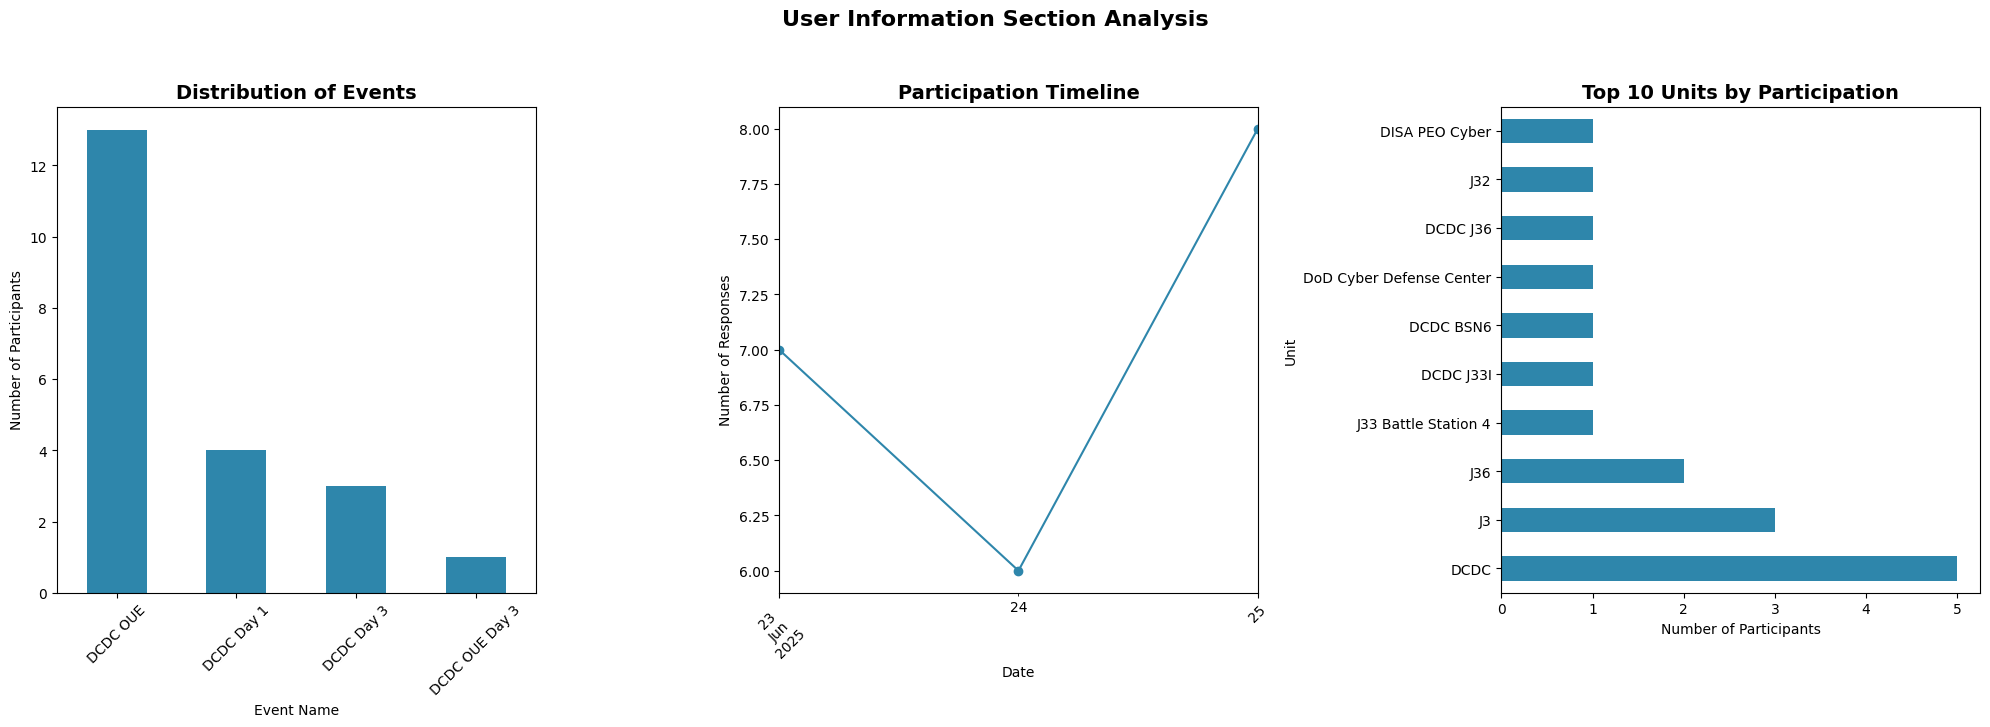

In [8]:
# User Information Visualizations
fig = plt.figure(figsize=(20, 12))

# 1. Event participation distribution
ax1 = plt.subplot(2, 3, 1)
event_data = df['user_information.event'].value_counts()
event_data.plot(kind='bar', ax=ax1, color=COLORS['primary'])
ax1.set_title('Distribution of Events', fontsize=14, fontweight='bold')
ax1.set_xlabel('Event Name')
ax1.set_ylabel('Number of Participants')
ax1.tick_params(axis='x', rotation=45)

# 2. Participation timeline
ax2 = plt.subplot(2, 3, 2)
df['user_information.date'] = pd.to_datetime(df['user_information.date'])
date_counts = df['user_information.date'].value_counts().sort_index()
date_counts.plot(kind='line', ax=ax2, color=COLORS['primary'], marker='o')
ax2.set_title('Participation Timeline', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Responses')
ax2.tick_params(axis='x', rotation=45)

# 3. Unit distribution (top 10)
ax3 = plt.subplot(2, 3, 3)
unit_data = df['user_information.unit'].value_counts().head(10)
unit_data.plot(kind='barh', ax=ax3, color=COLORS['primary'])
ax3.set_title('Top 10 Units by Participation', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Participants')
ax3.set_ylabel('Unit')

# # 4. Rank distribution word cloud style (simplified as bar chart)
# ax4 = plt.subplot(2, 3, 4)
# rank_data = df['user_information.rank_name'].value_counts().head(15)
# rank_data.plot(kind='pie', ax=ax4, autopct='%1.1f%%', startangle=90)
# ax4.set_title('Rank Distribution', fontsize=14, fontweight='bold')
# ax4.set_ylabel('')

# # 5. Contact information completion rates
# ax5 = plt.subplot(2, 3, 5)
# contact_fields = ['user_information.email', 'user_information.phone']
# completion_rates = [df[field].notna().mean() for field in contact_fields]
# ax5.bar(['Email', 'Phone'], completion_rates, color=[COLORS['success'], COLORS['info']])
# ax5.set_title('Contact Information Completion Rates', fontsize=14, fontweight='bold')
# ax5.set_ylabel('Completion Rate')
# ax5.set_ylim(0, 1)
# for i, v in enumerate(completion_rates):
#     ax5.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

# 6. Data quality summary
# ax6 = plt.subplot(2, 3, 6)
# quality_data = {
#     'Complete Records': (df[['user_information.event', 'user_information.date', 
#                             'user_information.rank_name', 'user_information.unit']].notna().all(axis=1)).sum(),
#     'Partial Records': len(df) - (df[['user_information.event', 'user_information.date', 
#                                       'user_information.rank_name', 'user_information.unit']].notna().all(axis=1)).sum()
# }
# ax6.pie(quality_data.values(), labels=quality_data.keys(), autopct='%1.1f%%', 
#         colors=[COLORS['primary'], COLORS['secondary']], startangle=90)
# ax6.set_title('Data Completeness', fontsize=14, fontweight='bold')

plt.suptitle('User Information Section Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 3. Role and Echelon Section Analysis

In [9]:
# Analyze role_and_echelon section
role_summary = processor.get_section_summary('role_and_echelon')
print("Role and Echelon Fields:")
for field, data in role_summary['field_summaries'].items():
    print(f"  - {field}: {data['field_type']} (completion: {data['completion_rate']:.1%})")

Role and Echelon Fields:
  - role_and_echelon.current_role_status: radio (completion: 100.0%)
  - role_and_echelon.is_cyber_operator: radio (completion: 100.0%)
  - role_and_echelon.cyber_ops_division_team: text (completion: 81.0%)
  - role_and_echelon.echelon: checkbox (completion: 100.0%)
  - role_and_echelon.duties: checkbox (completion: 100.0%)
  - role_and_echelon.other_duties: text (completion: 19.0%)


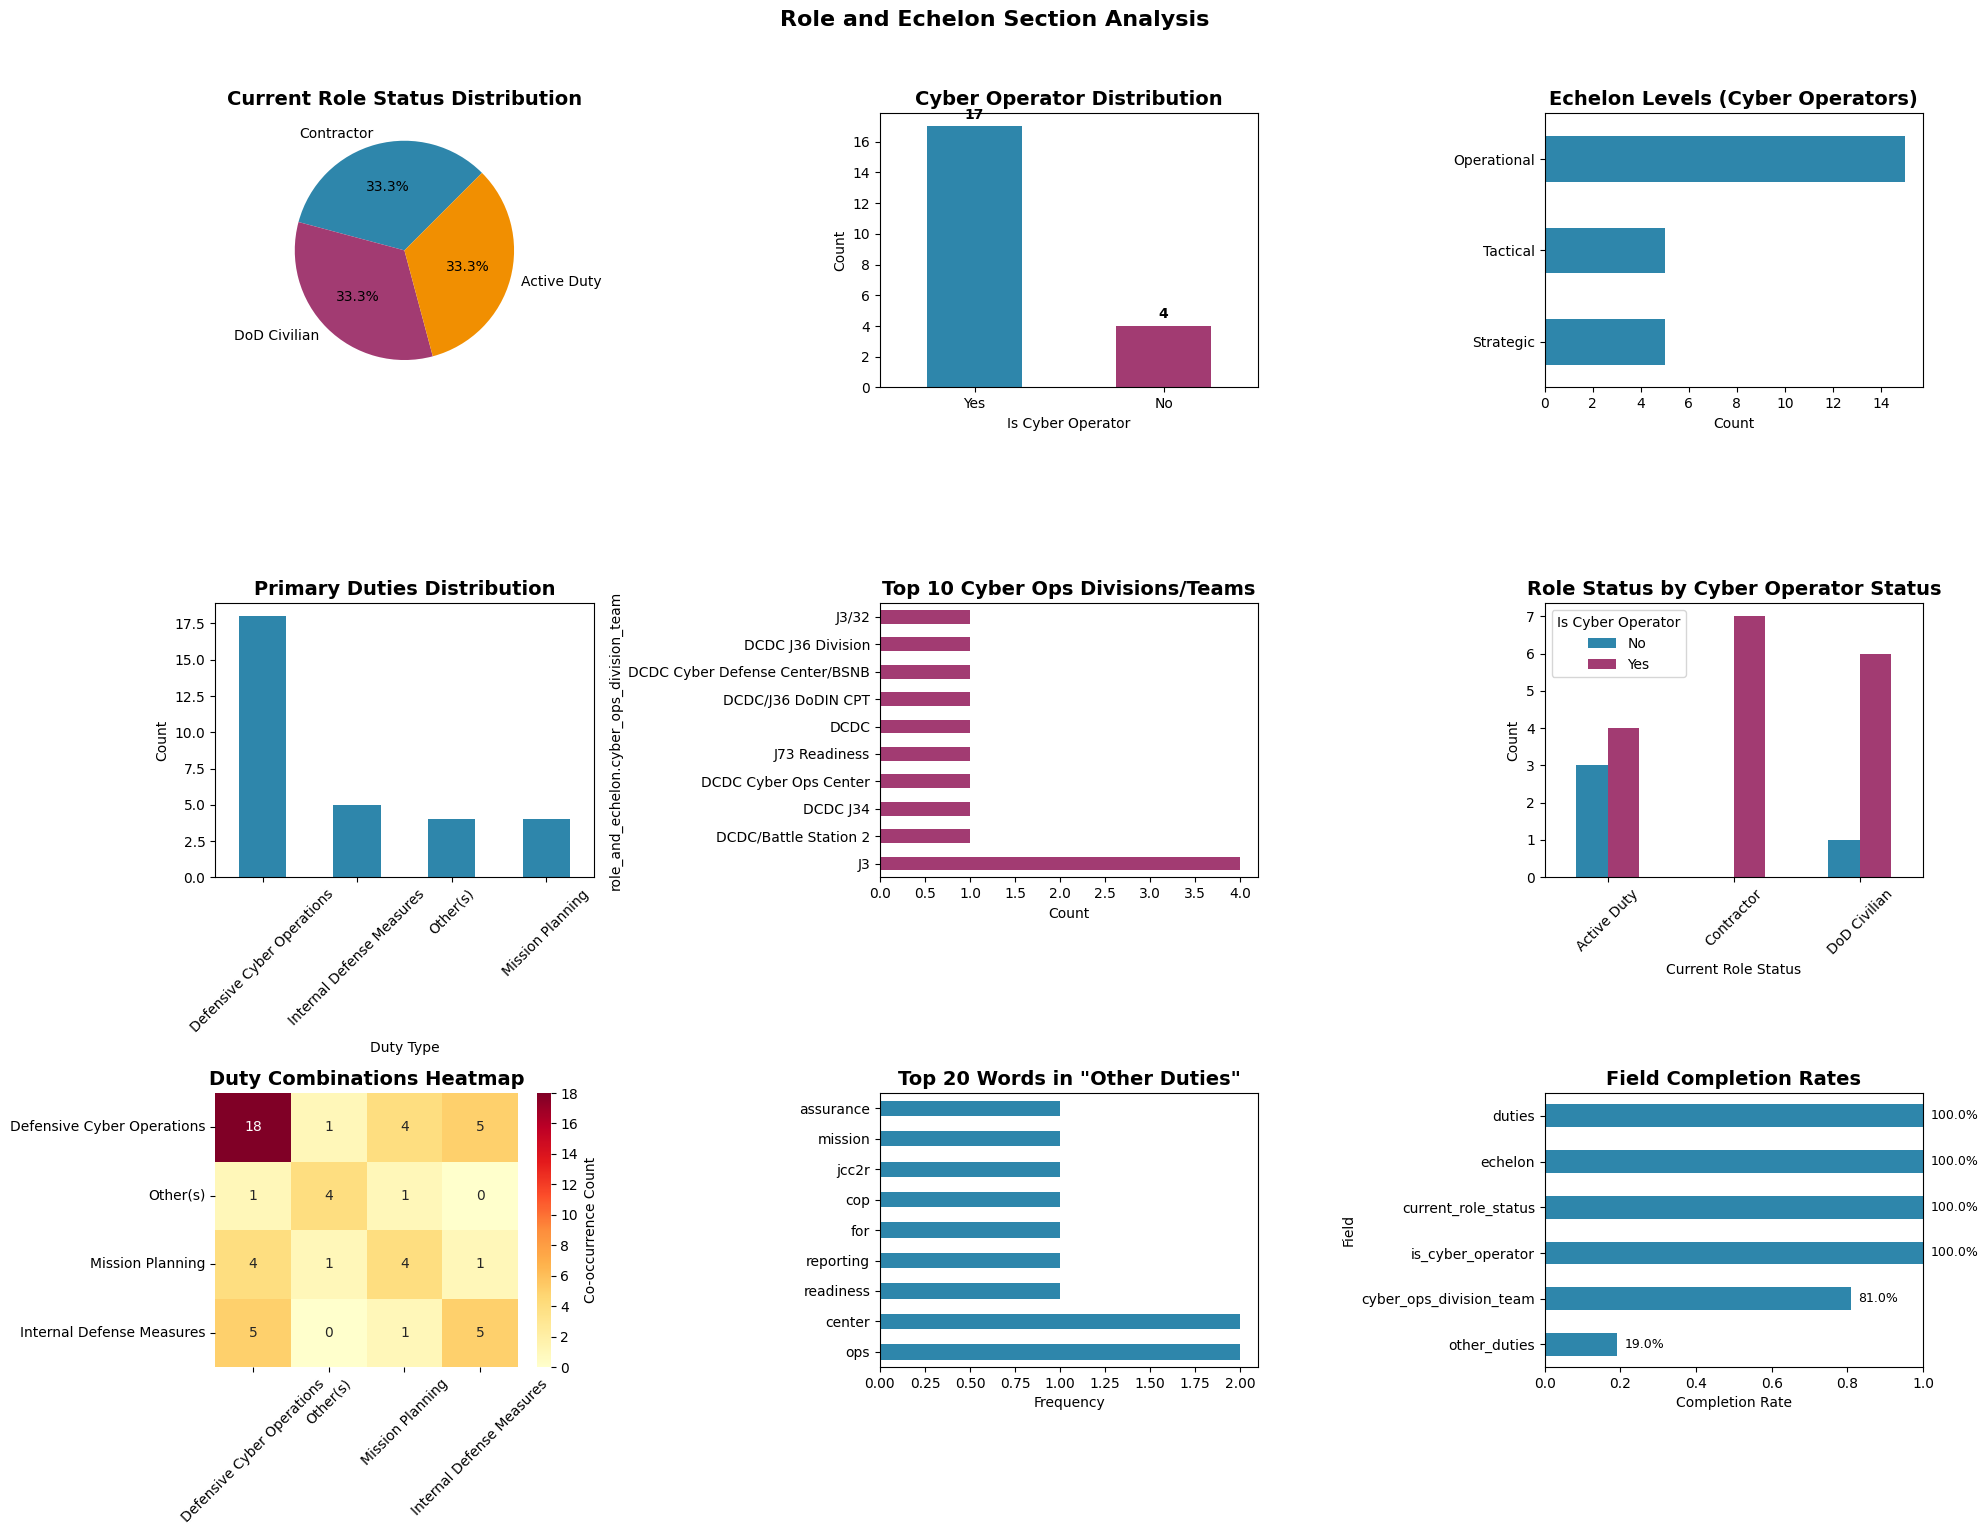

In [10]:
# Role and Echelon Visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Current role status distribution
ax1 = plt.subplot(3, 3, 1)
role_status = df['role_and_echelon.current_role_status'].value_counts()
colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary'], COLORS['quaternary']][:len(role_status)]
role_status.plot(kind='pie', ax=ax1, autopct='%1.1f%%', colors=colors, startangle=45)
ax1.set_title('Current Role Status Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('')

# 2. Cyber operator distribution
ax2 = plt.subplot(3, 3, 2)
cyber_op = df['role_and_echelon.is_cyber_operator'].value_counts()
cyber_op.plot(kind='bar', ax=ax2, color=[COLORS['primary'], COLORS['secondary']])
ax2.set_title('Cyber Operator Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Is Cyber Operator')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)
for i, v in enumerate(cyber_op.values):
    ax2.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 3. Echelon distribution (for cyber operators)
ax3 = plt.subplot(3, 3, 3)
cyber_ops_df = df[df['role_and_echelon.is_cyber_operator'] == 'Yes']
if not cyber_ops_df.empty and 'role_and_echelon.echelon' in cyber_ops_df.columns:
    # Parse echelon data (assuming it's a multi-select field)
    echelon_counts = {}
    for echelons in cyber_ops_df['role_and_echelon.echelon'].dropna():
        if isinstance(echelons, list):
            for echelon in echelons:
                echelon_counts[echelon] = echelon_counts.get(echelon, 0) + 1
        else:
            # Handle if it's stored as string
            for echelon in str(echelons).split('; '):
                if echelon:
                    echelon_counts[echelon] = echelon_counts.get(echelon, 0) + 1
    
    if echelon_counts:
        echelon_df = pd.Series(echelon_counts).sort_values(ascending=True)
        echelon_df.plot(kind='barh', ax=ax3, color=COLORS['primary'])
        ax3.set_title('Echelon Levels (Cyber Operators)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Count')
else:
    ax3.text(0.5, 0.5, 'No cyber operator echelon data', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Echelon Levels (Cyber Operators)', fontsize=14, fontweight='bold')

# 4. Duties distribution (multi-select analysis)
ax4 = plt.subplot(3, 3, 4)
duties_counts = {}
for duties in df['role_and_echelon.duties'].dropna():
    if isinstance(duties, list):
        for duty in duties:
            duties_counts[duty] = duties_counts.get(duty, 0) + 1
    else:
        # Handle if it's stored as string
        for duty in str(duties).split('; '):
            if duty:
                duties_counts[duty] = duties_counts.get(duty, 0) + 1

if duties_counts:
    duties_df = pd.Series(duties_counts).sort_values(ascending=False)
    duties_df.plot(kind='bar', ax=ax4, color=COLORS['primary'])
    ax4.set_title('Primary Duties Distribution', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Duty Type')
    ax4.set_ylabel('Count')
    ax4.tick_params(axis='x', rotation=45)

# 5. Cyber division/team distribution
ax5 = plt.subplot(3, 3, 5)
if 'role_and_echelon.cyber_ops_division_team' in df.columns:
    cyber_teams = df['role_and_echelon.cyber_ops_division_team'].dropna().value_counts().head(10)
    if not cyber_teams.empty:
        cyber_teams.plot(kind='barh', ax=ax5, color=COLORS['secondary'])
        ax5.set_title('Top 10 Cyber Ops Divisions/Teams', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Count')
    else:
        ax5.text(0.5, 0.5, 'No cyber team data available', ha='center', va='center', transform=ax5.transAxes)

# 6. Role status by cyber operator status
ax6 = plt.subplot(3, 3, 6)
role_cyber_cross = pd.crosstab(df['role_and_echelon.current_role_status'], 
                               df['role_and_echelon.is_cyber_operator'])
role_cyber_cross.plot(kind='bar', ax=ax6, color=[COLORS['primary'], COLORS['secondary']])
ax6.set_title('Role Status by Cyber Operator Status', fontsize=14, fontweight='bold')
ax6.set_xlabel('Current Role Status')
ax6.set_ylabel('Count')
ax6.legend(title='Is Cyber Operator')
ax6.tick_params(axis='x', rotation=45)

# 7. Duty combinations heatmap
ax7 = plt.subplot(3, 3, 7)
# Create a co-occurrence matrix for duties
duty_combinations = []
for duties in df['role_and_echelon.duties'].dropna():
    if isinstance(duties, list):
        duty_combinations.append(duties)
    else:
        duty_combinations.append(str(duties).split('; '))

# Count co-occurrences
unique_duties = list(duties_counts.keys()) if duties_counts else []
co_matrix = pd.DataFrame(0, index=unique_duties[:6], columns=unique_duties[:6])  # Top 6 for readability

for combo in duty_combinations:
    for i, duty1 in enumerate(combo):
        for duty2 in combo[i:]:
            if duty1 in co_matrix.index and duty2 in co_matrix.columns:
                co_matrix.loc[duty1, duty2] += 1
                if duty1 != duty2:
                    co_matrix.loc[duty2, duty1] += 1

if not co_matrix.empty:
    sns.heatmap(co_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'Co-occurrence Count'})
    ax7.set_title('Duty Combinations Heatmap', fontsize=14, fontweight='bold')
    ax7.tick_params(axis='x', rotation=45)
    ax7.tick_params(axis='y', rotation=0)

# 8. Other duties word frequency (simplified)
ax8 = plt.subplot(3, 3, 8)
other_duties = df['role_and_echelon.other_duties'].dropna()
if not other_duties.empty:
    # Simple word frequency analysis
    all_words = ' '.join(other_duties.astype(str)).lower().split()
    word_freq = pd.Series(all_words).value_counts().head(20)
    word_freq.plot(kind='barh', ax=ax8, color=COLORS['primary'])
    ax8.set_title('Top 20 Words in "Other Duties"', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Frequency')
else:
    ax8.text(0.5, 0.5, 'No "other duties" data', ha='center', va='center', transform=ax8.transAxes)

# 9. Completeness by field
ax9 = plt.subplot(3, 3, 9)
role_fields = [col for col in df.columns if col.startswith('role_and_echelon.')]
completeness = [(col.split('.')[-1], df[col].notna().mean()) for col in role_fields]
completeness_df = pd.DataFrame(completeness, columns=['Field', 'Completion Rate']).sort_values('Completion Rate')
completeness_df.plot(x='Field', y='Completion Rate', kind='barh', ax=ax9, color=COLORS['primary'], legend=False)
ax9.set_title('Field Completion Rates', fontsize=14, fontweight='bold')
ax9.set_xlabel('Completion Rate')
ax9.set_xlim(0, 1)
for i, (field, rate) in enumerate(completeness_df.values):
    ax9.text(rate + 0.02, i, f'{rate:.1%}', va='center', fontsize=9)

plt.suptitle('Role and Echelon Section Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 4. Operational JCC2 Experience Section Analysis

In [11]:
# Analyze operational_jcc2_experience section
ops_summary = processor.get_section_summary('operational_jcc2_experience')
print("Operational JCC2 Experience Fields:")
experience_fields = {}
for field, data in ops_summary['field_summaries'].items():
    field_name = field.split('.')[-1]
    if field_name.startswith('exp_'):
        experience_fields[field_name] = data
        print(f"  - {field_name}: {data['field_type']} (completion: {data['completion_rate']:.1%})")

Operational JCC2 Experience Fields:
  - exp_cyberoperations: radio (completion: 100.0%)
  - exp_yourcurrentrole: radio (completion: 100.0%)
  - exp_jcc2experience: radio (completion: 100.0%)
  - exp_app_a2it: radio (completion: 28.6%)
  - exp_app_cad: radio (completion: 4.8%)
  - exp_app_codex: radio (completion: 4.8%)
  - exp_app_crucible: radio (completion: 4.8%)
  - exp_app_cyber9line: radio (completion: 9.5%)
  - exp_app_dispatch: radio (completion: 9.5%)
  - exp_app_jcc2cyberops: radio (completion: 33.3%)
  - exp_app_jcc2readiness: radio (completion: 38.1%)
  - exp_app_madss: radio (completion: 38.1%)
  - exp_app_rally: radio (completion: 76.2%)
  - exp_app_redmap: radio (completion: 9.5%)
  - exp_app_sigact: radio (completion: 81.0%)
  - exp_app_threathub: radio (completion: 23.8%)
  - exp_app_triage: radio (completion: 9.5%)
  - exp_app_unity: radio (completion: 33.3%)


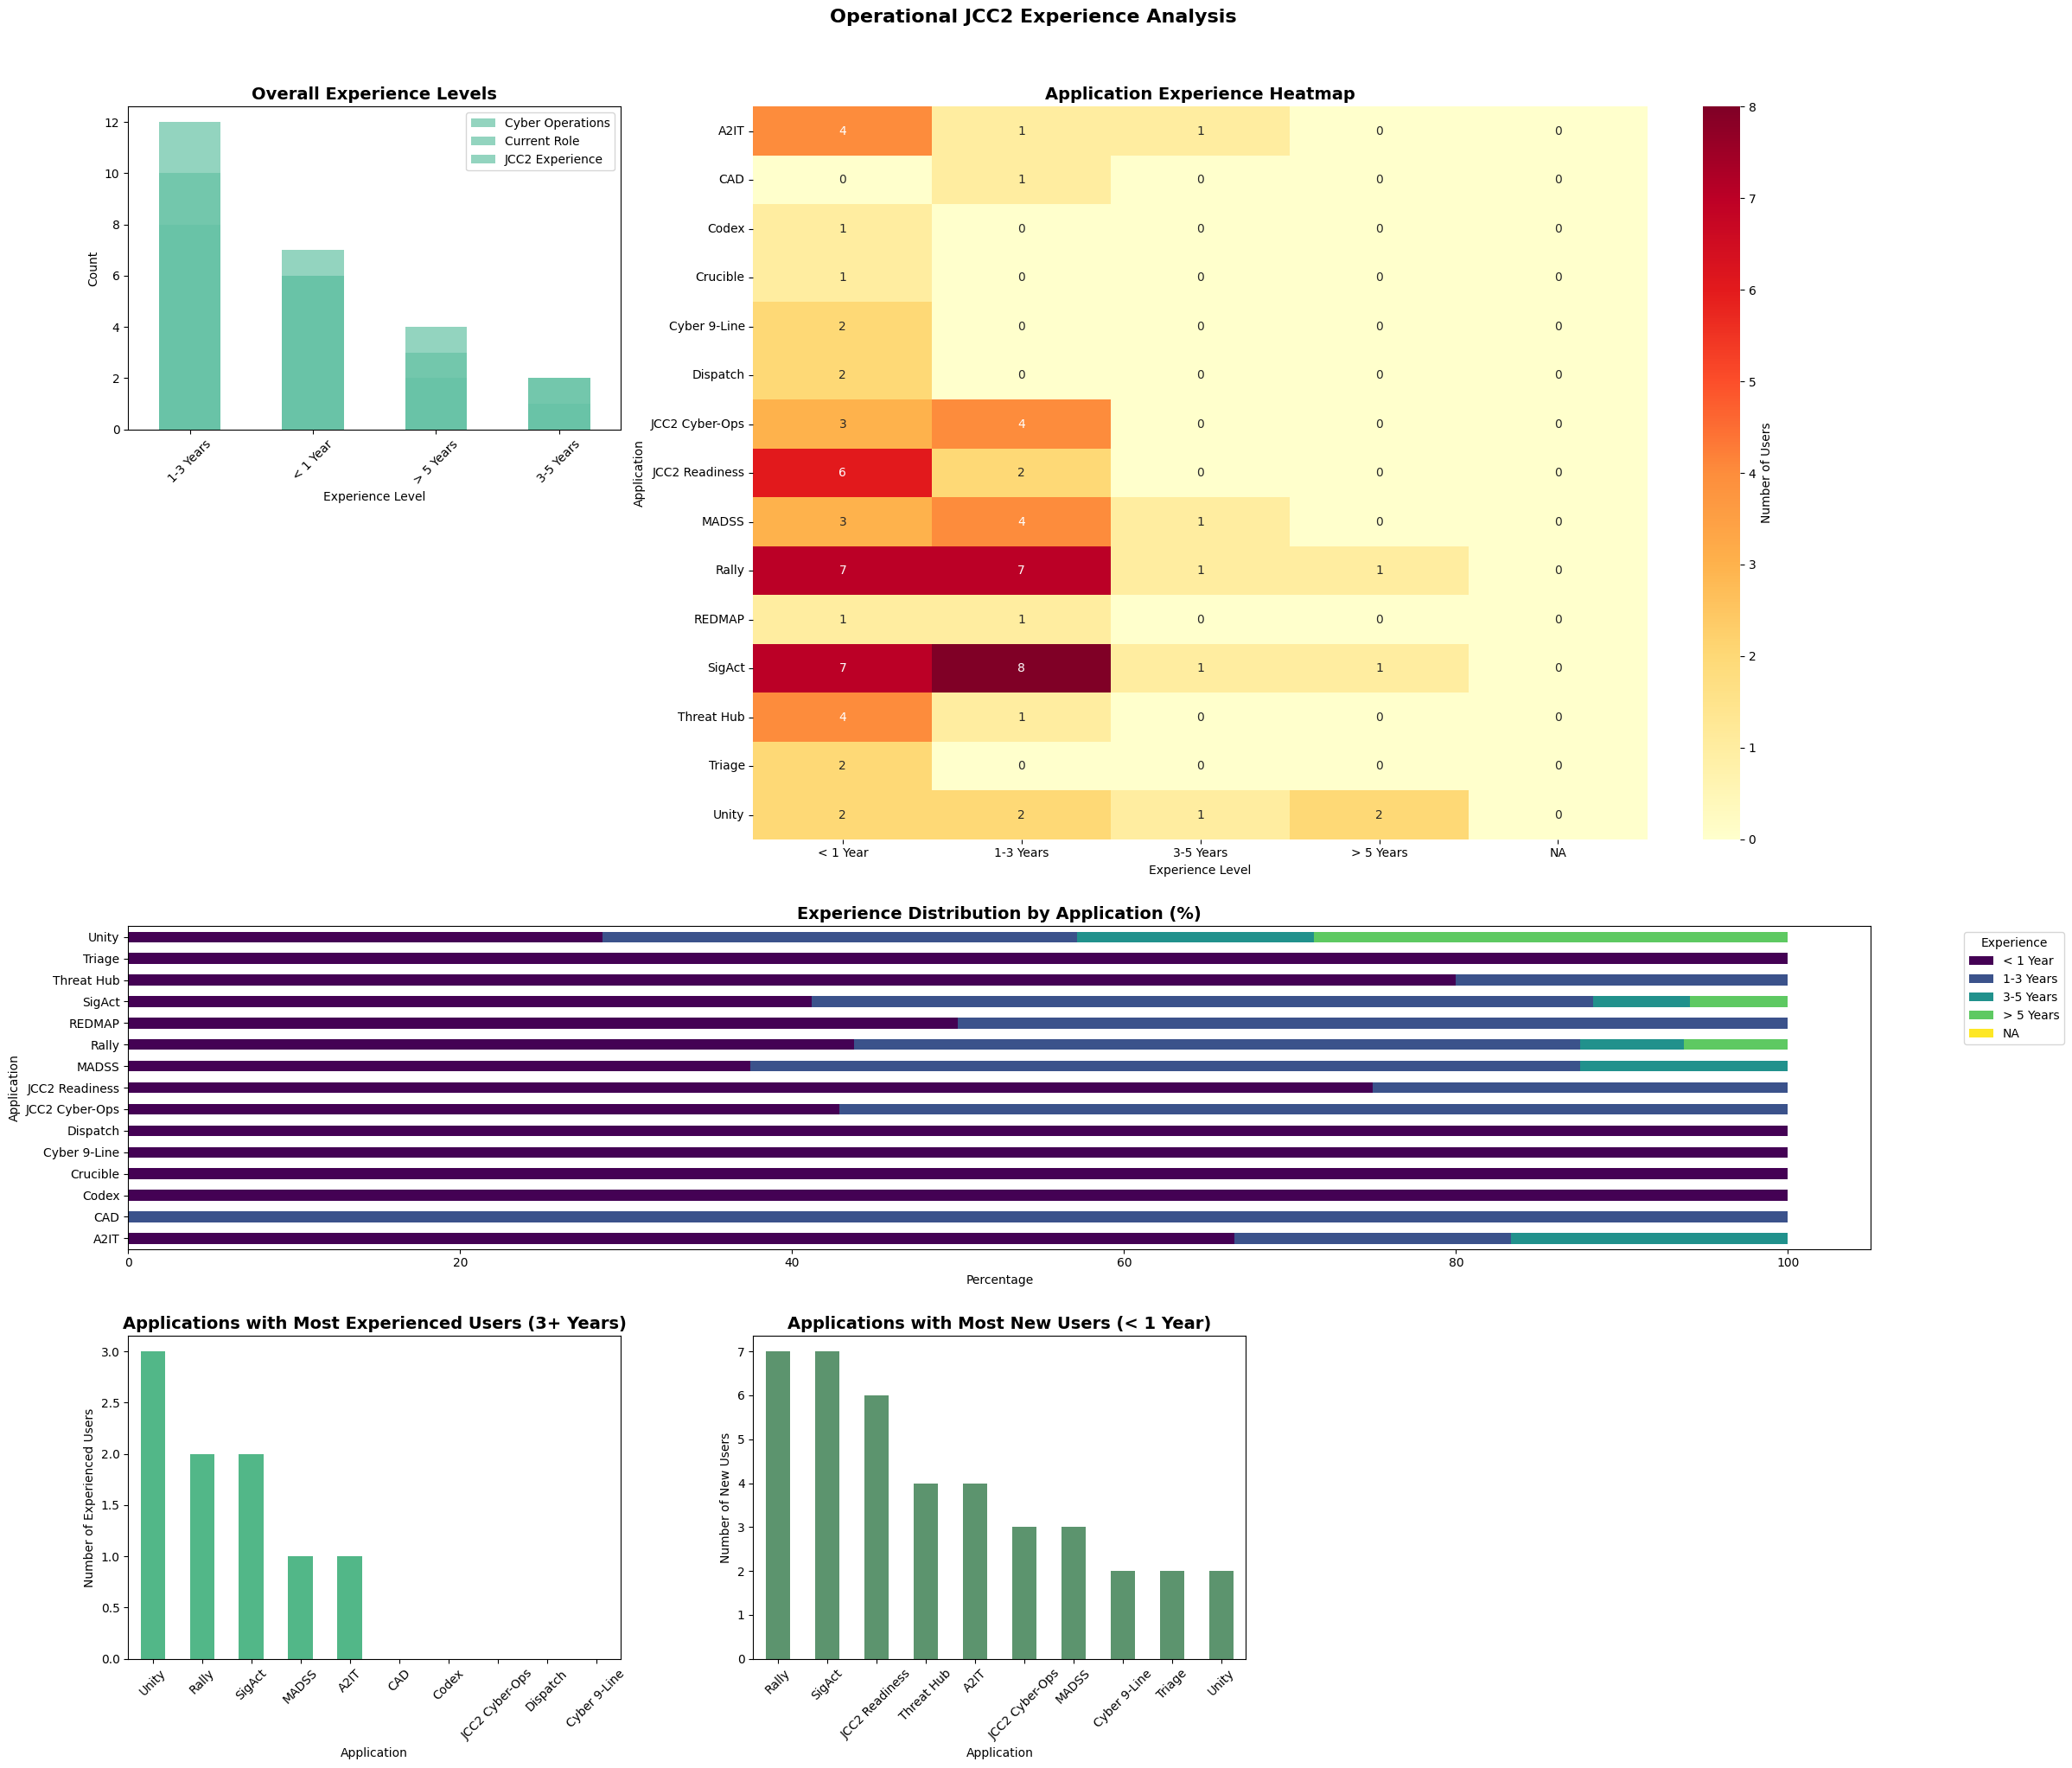

In [12]:
# Operational JCC2 Experience Visualizations
fig = plt.figure(figsize=(24, 20))

# Extract experience levels for all applications
app_experience = {}
experience_mapping = {
    'exp_cyberoperations': 'Cyber Operations',
    'exp_yourcurrentrole': 'Current Role',
    'exp_jcc2experience': 'JCC2 Experience',
    'exp_app_a2it': 'A2IT',
    'exp_app_cad': 'CAD',
    'exp_app_codex': 'Codex',
    'exp_app_crucible': 'Crucible',
    'exp_app_cyber9line': 'Cyber 9-Line',
    'exp_app_dispatch': 'Dispatch',
    'exp_app_jcc2cyberops': 'JCC2 Cyber-Ops',
    'exp_app_jcc2readiness': 'JCC2 Readiness',
    'exp_app_madss': 'MADSS',
    'exp_app_rally': 'Rally',
    'exp_app_redmap': 'REDMAP',
    'exp_app_sigact': 'SigAct',
    'exp_app_threathub': 'Threat Hub',
    'exp_app_triage': 'Triage',
    'exp_app_unity': 'Unity'
}

# 1. Overall experience distribution (first 3 fields)
ax1 = plt.subplot(4, 3, 1)
overall_exp_fields = ['exp_cyberoperations', 'exp_yourcurrentrole', 'exp_jcc2experience']
for i, field in enumerate(overall_exp_fields):
    if f'operational_jcc2_experience.{field}' in df.columns:
        exp_data = df[f'operational_jcc2_experience.{field}'].value_counts()
        exp_data.plot(kind='bar', ax=ax1, alpha=0.7, label=experience_mapping.get(field, field))
ax1.set_title('Overall Experience Levels', fontsize=14, fontweight='bold')
ax1.set_xlabel('Experience Level')
ax1.set_ylabel('Count')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Application experience heatmap
ax2 = plt.subplot(4, 3, (2, 6))  # Span multiple cells
app_exp_data = []
exp_order = ['< 1 Year', '1-3 Years', '3-5 Years', '> 5 Years', 'NA']
for field, label in experience_mapping.items():
    if field.startswith('exp_app_') and f'operational_jcc2_experience.{field}' in df.columns:
        counts = df[f'operational_jcc2_experience.{field}'].value_counts()
        row_data = [counts.get(exp, 0) for exp in exp_order]
        app_exp_data.append(row_data)

if app_exp_data:
    app_labels = [v for k, v in experience_mapping.items() if k.startswith('exp_app_')]
    exp_matrix = pd.DataFrame(app_exp_data, index=app_labels[:len(app_exp_data)], columns=exp_order)
    sns.heatmap(exp_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Number of Users'})
    ax2.set_title('Application Experience Heatmap', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Experience Level')
    ax2.set_ylabel('Application')

# 3. Experience distribution by application (stacked bar)
ax3 = plt.subplot(4, 3, (7, 9))  # Span multiple cells
if app_exp_data:
    exp_matrix_pct = exp_matrix.div(exp_matrix.sum(axis=1), axis=0) * 100
    exp_matrix_pct.plot(kind='barh', stacked=True, ax=ax3, colormap='viridis')
    ax3.set_title('Experience Distribution by Application (%)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Percentage')
    ax3.set_ylabel('Application')
    ax3.legend(title='Experience', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Applications with most experienced users
ax4 = plt.subplot(4, 3, 10)
experienced_users = {}
for field, label in experience_mapping.items():
    if field.startswith('exp_app_') and f'operational_jcc2_experience.{field}' in df.columns:
        exp_counts = df[f'operational_jcc2_experience.{field}'].value_counts()
        experienced = exp_counts.get('> 5 Years', 0) + exp_counts.get('3-5 Years', 0)
        experienced_users[label] = experienced

if experienced_users:
    exp_series = pd.Series(experienced_users).sort_values(ascending=False).head(10)
    exp_series.plot(kind='bar', ax=ax4, color=COLORS['success'])
    ax4.set_title('Applications with Most Experienced Users (3+ Years)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Application')
    ax4.set_ylabel('Number of Experienced Users')
    ax4.tick_params(axis='x', rotation=45)

# 5. New user distribution (< 1 Year)
ax5 = plt.subplot(4, 3, 11)
new_users = {}
for field, label in experience_mapping.items():
    if field.startswith('exp_app_') and f'operational_jcc2_experience.{field}' in df.columns:
        exp_counts = df[f'operational_jcc2_experience.{field}'].value_counts()
        new = exp_counts.get('< 1 Year', 0)
        new_users[label] = new

if new_users:
    new_series = pd.Series(new_users).sort_values(ascending=False).head(10)
    new_series.plot(kind='bar', ax=ax5, color=COLORS['info'])
    ax5.set_title('Applications with Most New Users (< 1 Year)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Application')
    ax5.set_ylabel('Number of New Users')
    ax5.tick_params(axis='x', rotation=45)

# 6. Application adoption rate (users with any experience vs NA)
# ax6 = plt.subplot(4, 3, 12)
# adoption_rates = {}
# for field, label in experience_mapping.items():
#     if field.startswith('exp_app_') and f'operational_jcc2_experience.{field}' in df.columns:
#         exp_counts = df[f'operational_jcc2_experience.{field}'].value_counts()
#         total_responses = exp_counts.sum()
#         na_count = exp_counts.get('NA', 0)
#         if total_responses > 0:
#             adoption_rate = (total_responses - na_count) / total_responses * 100
#             adoption_rates[label] = adoption_rate

# if adoption_rates:
#     adoption_series = pd.Series(adoption_rates).sort_values(ascending=True)
#     adoption_series.plot(kind='barh', ax=ax6, color=COLORS['primary'])
#     ax6.set_title('Application Adoption Rates', fontsize=14, fontweight='bold')
#     ax6.set_xlabel('Adoption Rate (%)')
#     ax6.set_ylabel('Application')
#     ax6.set_xlim(0, 100)
#     for i, (app, rate) in enumerate(adoption_series.items()):
#         ax6.text(rate + 1, i, f'{rate:.1f}%', va='center', fontsize=9)

plt.suptitle('Operational JCC2 Experience Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

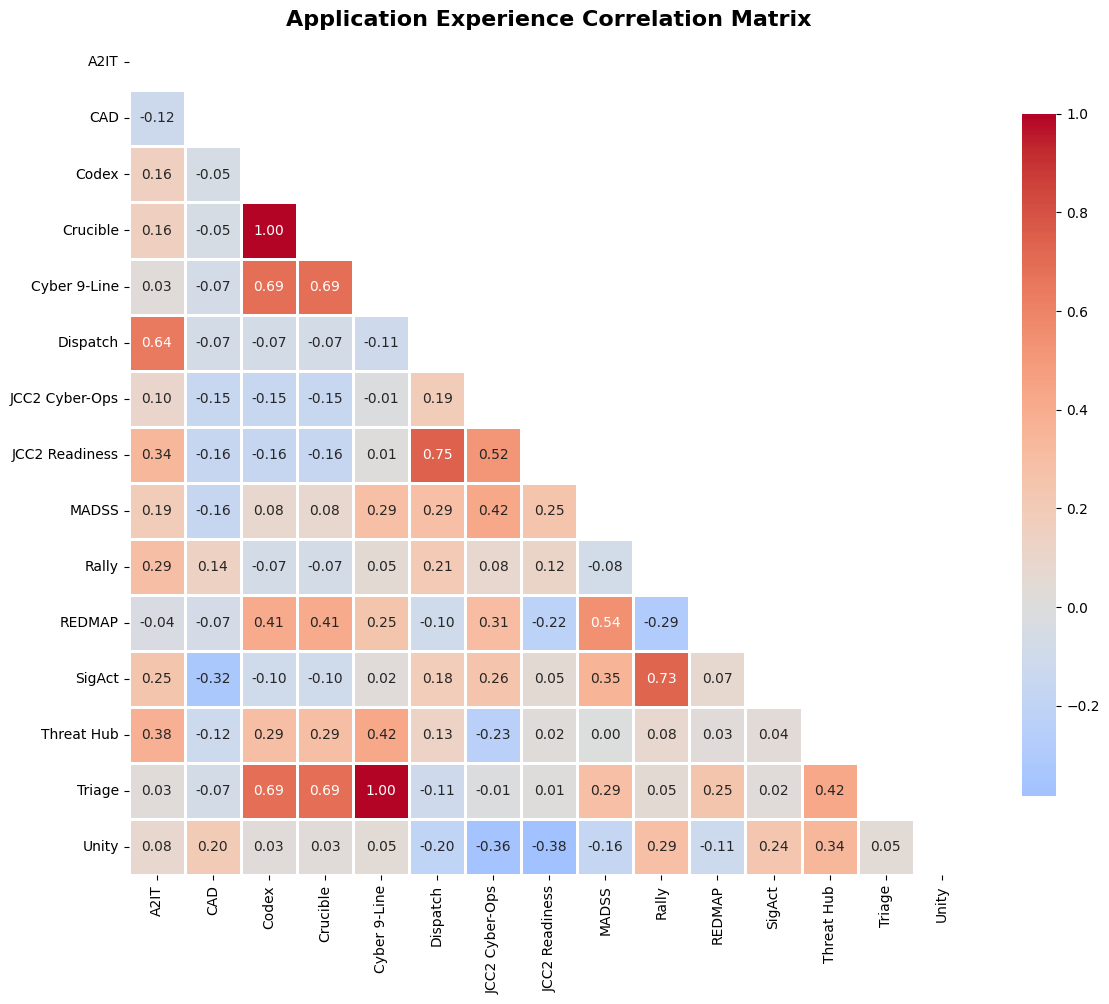

In [13]:
# Additional analysis: Experience correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Create numeric mapping for experience levels
exp_numeric_map = {
    '< 1 Year': 1,
    '1-3 Years': 2,
    '3-5 Years': 3,
    '> 5 Years': 4,
    'NA': 0
}

# Convert experience columns to numeric
exp_columns = []
exp_labels = []
for field, label in experience_mapping.items():
    if field.startswith('exp_app_') and f'operational_jcc2_experience.{field}' in df.columns:
        col_name = f'operational_jcc2_experience.{field}'
        df[f'{col_name}_numeric'] = df[col_name].map(exp_numeric_map).fillna(0)
        exp_columns.append(f'{col_name}_numeric')
        exp_labels.append(label)

if exp_columns:
    # Calculate correlation matrix
    corr_matrix = df[exp_columns].corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": .8},
                xticklabels=exp_labels, yticklabels=exp_labels, ax=ax)
    ax.set_title('Application Experience Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Clean up numeric columns
    df.drop(columns=exp_columns, inplace=True)

# 5. MOP 1.1.1 Intelligence Data Section Analysis

In [14]:
# Analyze mop_1_1_1 section
mop_summary = processor.get_section_summary('mop_1_1_1')
print("MOP 1.1.1 Intelligence Data Fields:")
intel_fields = {}
for field, data in mop_summary['field_summaries'].items():
    field_name = field.split('.')[-1]
    intel_fields[field_name] = data
    print(f"  - {field_name}: {data['field_type']} (completion: {data['completion_rate']:.1%})")

MOP 1.1.1 Intelligence Data Fields:
  - intelligence_data_provided_jcc2cyberops: radio (completion: 33.3%)
  - intelligence_data_completion_of_role_jcc2cyberops: radio (completion: 33.3%)
  - intelligence_data_provided_jcc2readiness: radio (completion: 38.1%)
  - intelligence_data_completion_of_role_jcc2readiness: radio (completion: 38.1%)
  - intelligence_data_provided_a2it: radio (completion: 28.6%)
  - intelligence_data_completion_of_role_a2it: radio (completion: 28.6%)
  - intelligence_data_provided_cad: radio (completion: 4.8%)
  - intelligence_data_completion_of_role_cad: radio (completion: 4.8%)
  - intelligence_data_provided_codex: radio (completion: 4.8%)
  - intelligence_data_completion_of_role_codex: radio (completion: 4.8%)
  - intelligence_data_provided_crucible: radio (completion: 4.8%)
  - intelligence_data_completion_of_role_crucible: radio (completion: 4.8%)
  - intelligence_data_provided_cyber9line: radio (completion: 9.5%)
  - intelligence_data_completion_of_role_cyb

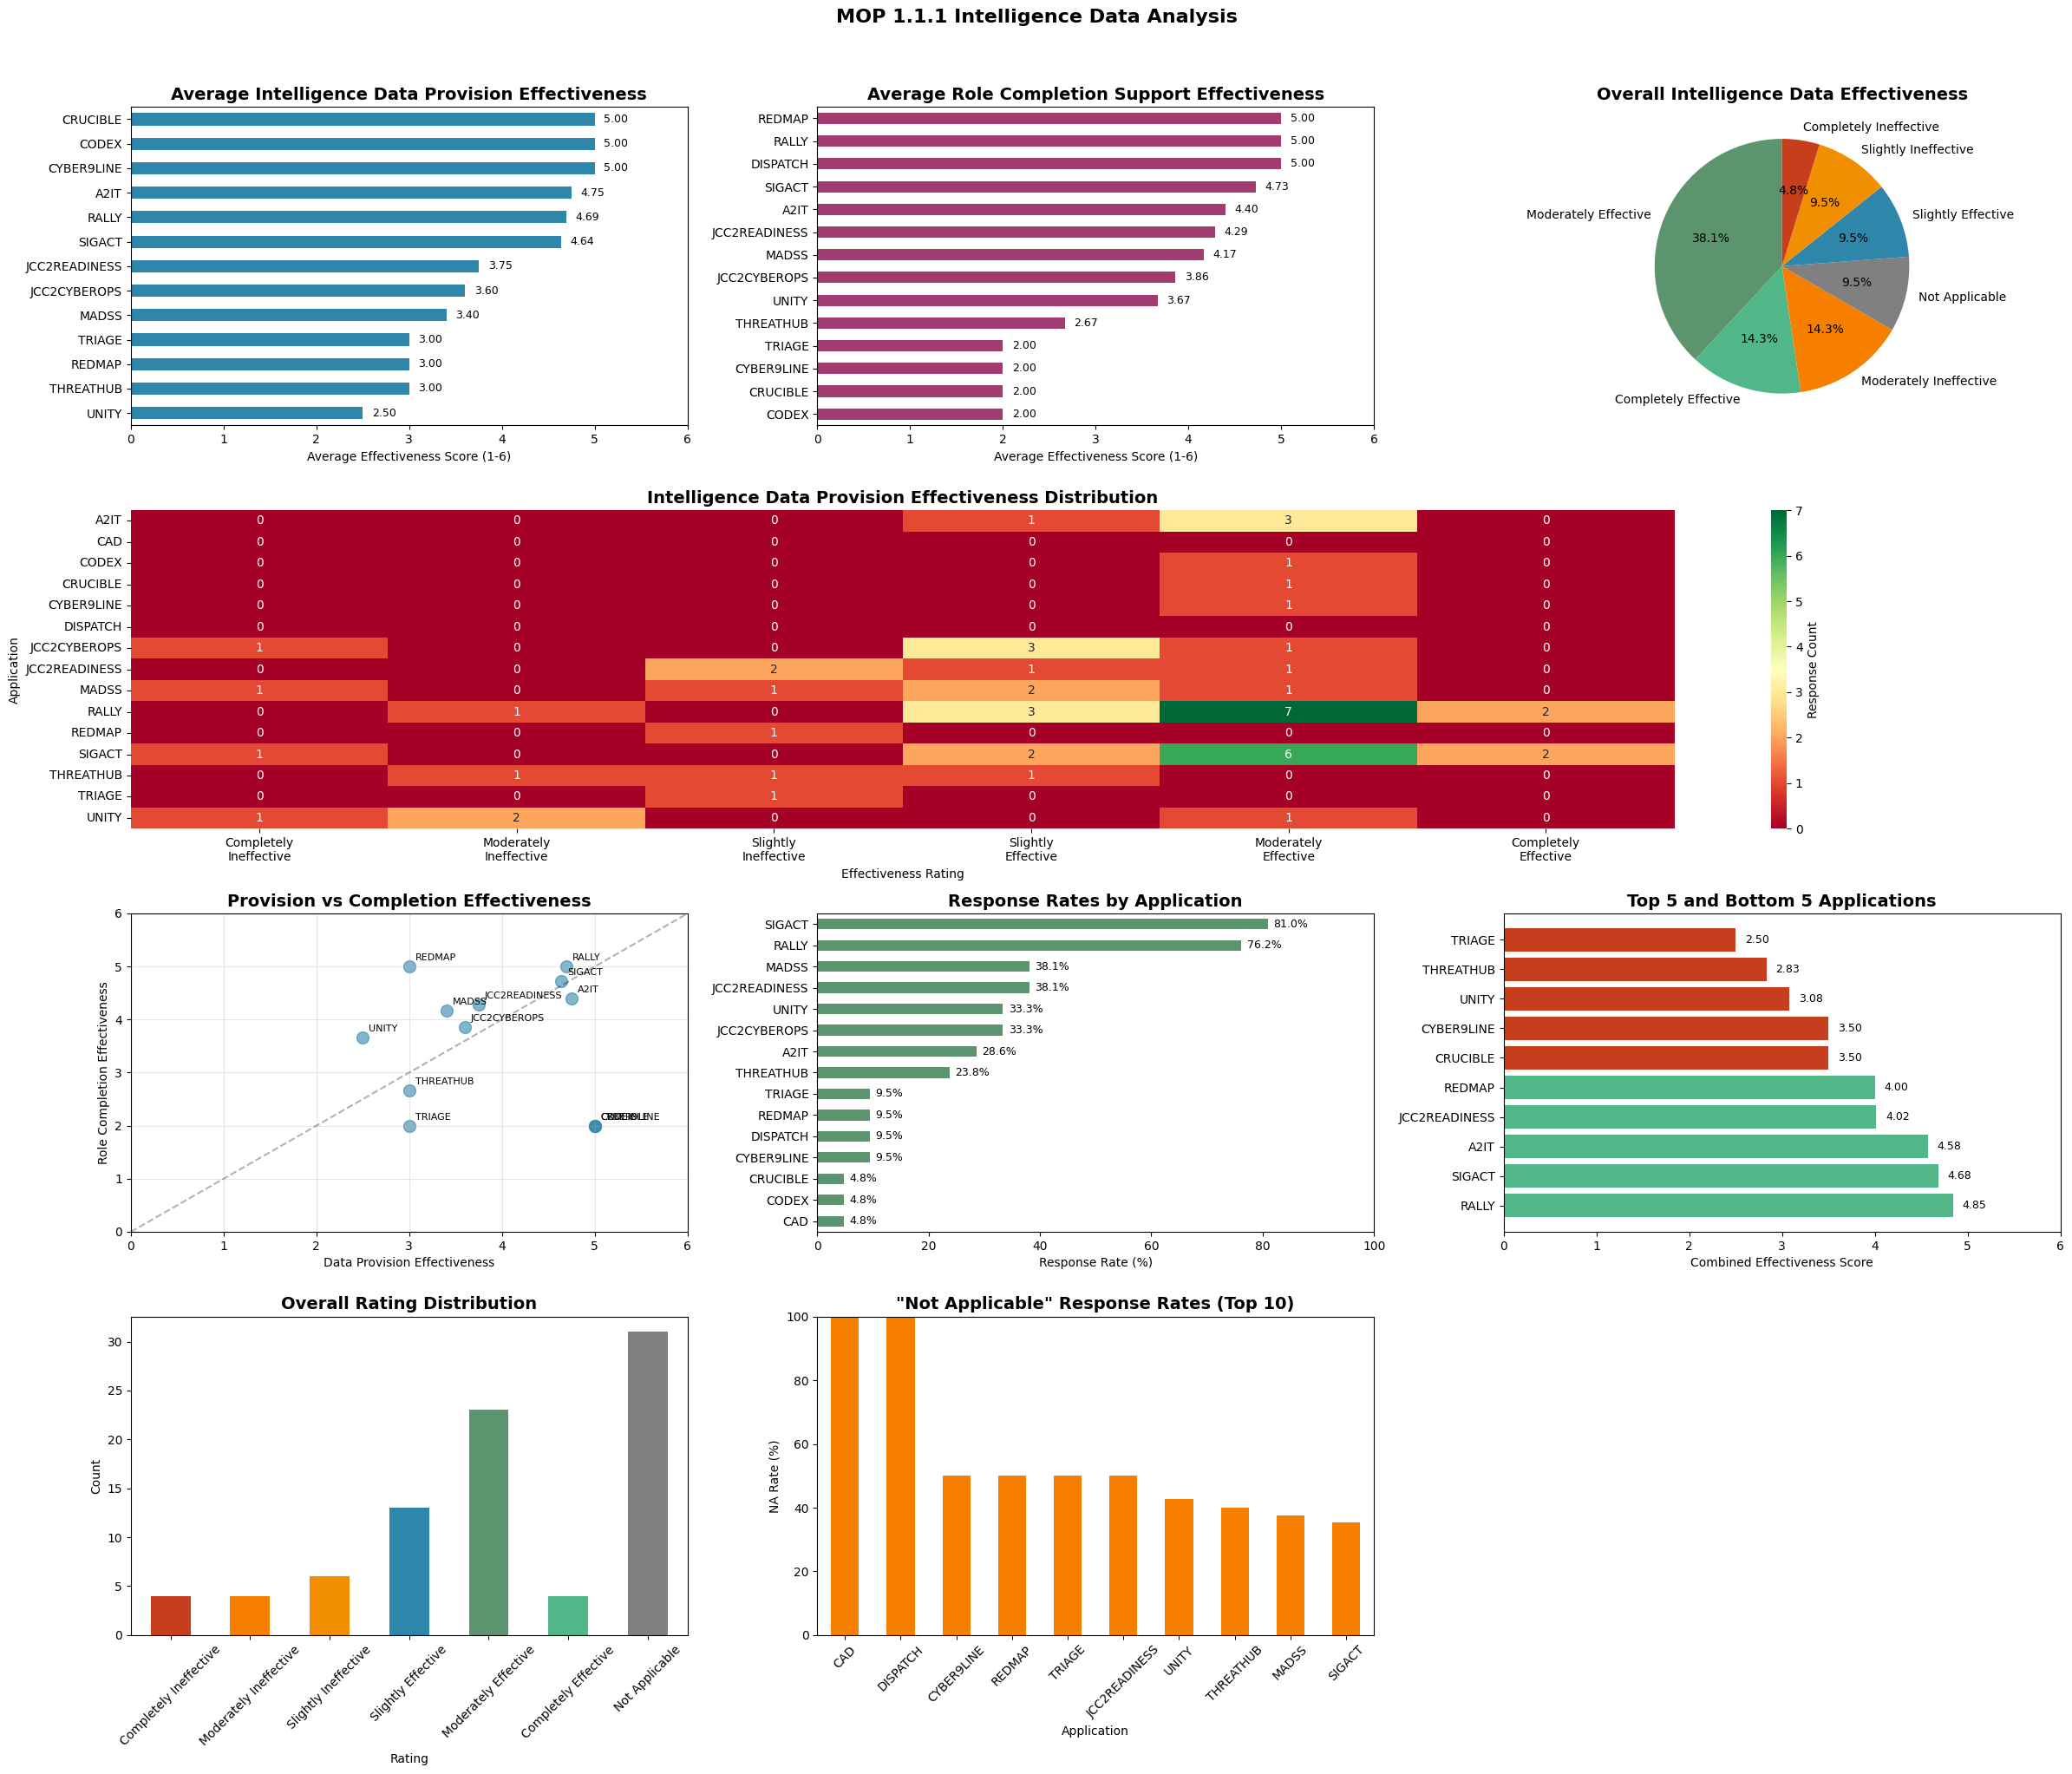

In [15]:
# MOP 1.1.1 Intelligence Data Visualizations
fig = plt.figure(figsize=(24, 20))

# Extract application names from field names
intel_apps = set()
for field in mop_summary['field_summaries'].keys():
    parts = field.split('_')
    if len(parts) > 3:
        app_name = '_'.join(parts[3:]) if parts[2] in ['provided', 'completion'] else parts[-1]
        intel_apps.add(app_name)

intel_apps = sorted(list(intel_apps))

# 1. Intelligence data provision by application
ax1 = plt.subplot(4, 3, 1)
provided_data = {}
for app in intel_apps:
    field_name = f'mop_1_1_1.intelligence_data_provided_{app}'
    if field_name in df.columns:
        counts = df[field_name].value_counts()
        provided_data[app] = counts

if provided_data:
    # Calculate effectiveness scores
    effectiveness_map = {
        'Completely Ineffective': 1, 'Moderately Ineffective': 2, 'Slightly Ineffective': 3,
        'Slightly Effective': 4, 'Moderately Effective': 5, 'Completely Effective': 6,
        'Not Applicable': 0
    }
    
    avg_scores = {}
    for app, counts in provided_data.items():
        total_score = sum(effectiveness_map.get(rating, 0) * count for rating, count in counts.items())
        total_responses = sum(count for rating, count in counts.items() if rating != 'Not Applicable')
        if total_responses > 0:
            avg_scores[app.upper()] = total_score / total_responses
    
    if avg_scores:
        scores_series = pd.Series(avg_scores).sort_values(ascending=True)
        scores_series.plot(kind='barh', ax=ax1, color=COLORS['primary'])
        ax1.set_title('Average Intelligence Data Provision Effectiveness', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Average Effectiveness Score (1-6)')
        ax1.set_xlim(0, 6)
        for i, (app, score) in enumerate(scores_series.items()):
            ax1.text(score + 0.1, i, f'{score:.2f}', va='center', fontsize=9)

# 2. Role completion effectiveness by application
ax2 = plt.subplot(4, 3, 2)
completion_data = {}
for app in intel_apps:
    field_name = f'mop_1_1_1.intelligence_data_completion_of_role_{app}'
    if field_name in df.columns:
        counts = df[field_name].value_counts()
        completion_data[app] = counts

if completion_data:
    avg_completion_scores = {}
    for app, counts in completion_data.items():
        total_score = sum(effectiveness_map.get(rating, 0) * count for rating, count in counts.items())
        total_responses = sum(count for rating, count in counts.items() if rating != 'Not Applicable')
        if total_responses > 0:
            avg_completion_scores[app.upper()] = total_score / total_responses
    
    if avg_completion_scores:
        comp_series = pd.Series(avg_completion_scores).sort_values(ascending=True)
        comp_series.plot(kind='barh', ax=ax2, color=COLORS['secondary'])
        ax2.set_title('Average Role Completion Support Effectiveness', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Average Effectiveness Score (1-6)')
        ax2.set_xlim(0, 6)
        for i, (app, score) in enumerate(comp_series.items()):
            ax2.text(score + 0.1, i, f'{score:.2f}', va='center', fontsize=9)

# 3. Overall intelligence effectiveness
ax3 = plt.subplot(4, 3, 3)
if 'mop_1_1_1.intelligence_data_overall_effectiveness' in df.columns:
    overall_counts = df['mop_1_1_1.intelligence_data_overall_effectiveness'].value_counts()
    colors_map = {
        'Completely Effective': COLORS['success'],
        'Moderately Effective': COLORS['info'],
        'Slightly Effective': COLORS['primary'],
        'Slightly Ineffective': COLORS['tertiary'],
        'Moderately Ineffective': COLORS['warning'],
        'Completely Ineffective': COLORS['quaternary'],
        'Not Applicable': 'gray'
    }
    colors = [colors_map.get(rating, 'gray') for rating in overall_counts.index]
    overall_counts.plot(kind='pie', ax=ax3, autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Overall Intelligence Data Effectiveness', fontsize=14, fontweight='bold')
    ax3.set_ylabel('')

# 4. Effectiveness comparison heatmap
ax4 = plt.subplot(4, 3, (4, 6))  # Span multiple cells
if provided_data and completion_data:
    # Create comparison matrix
    comparison_data = []
    app_labels = []
    
    for app in intel_apps:
        if app in provided_data and app in completion_data:
            app_labels.append(app.upper())
            row = []
            
            # Data provision scores
            for rating in ['Completely Ineffective', 'Moderately Ineffective', 'Slightly Ineffective',
                          'Slightly Effective', 'Moderately Effective', 'Completely Effective']:
                row.append(provided_data[app].get(rating, 0))
            
            comparison_data.append(row)
    
    if comparison_data:
        comp_df = pd.DataFrame(comparison_data, index=app_labels, 
                              columns=['Completely\nIneffective', 'Moderately\nIneffective', 'Slightly\nIneffective',
                                      'Slightly\nEffective', 'Moderately\nEffective', 'Completely\nEffective'])
        sns.heatmap(comp_df, annot=True, fmt='d', cmap='RdYlGn', ax=ax4, cbar_kws={'label': 'Response Count'})
        ax4.set_title('Intelligence Data Provision Effectiveness Distribution', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Effectiveness Rating')
        ax4.set_ylabel('Application')

# 5. Provision vs Completion scatter plot
ax5 = plt.subplot(4, 3, 7)
if avg_scores and avg_completion_scores:
    scatter_data = []
    for app in set(avg_scores.keys()) & set(avg_completion_scores.keys()):
        scatter_data.append({
            'app': app,
            'provision': avg_scores[app],
            'completion': avg_completion_scores[app]
        })
    
    if scatter_data:
        scatter_df = pd.DataFrame(scatter_data)
        ax5.scatter(scatter_df['provision'], scatter_df['completion'], s=100, alpha=0.6, color=COLORS['primary'])
        
        # Add labels
        for _, row in scatter_df.iterrows():
            ax5.annotate(row['app'], (row['provision'], row['completion']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # Add diagonal line
        ax5.plot([0, 6], [0, 6], 'k--', alpha=0.3)
        
        ax5.set_xlabel('Data Provision Effectiveness')
        ax5.set_ylabel('Role Completion Effectiveness')
        ax5.set_title('Provision vs Completion Effectiveness', fontsize=14, fontweight='bold')
        ax5.set_xlim(0, 6)
        ax5.set_ylim(0, 6)
        ax5.grid(True, alpha=0.3)

# 6. Response rate by application
ax6 = plt.subplot(4, 3, 8)
response_rates = {}
for app in intel_apps:
    field_name = f'mop_1_1_1.intelligence_data_provided_{app}'
    if field_name in df.columns:
        total = len(df)
        non_na = df[field_name].notna().sum()
        response_rates[app.upper()] = (non_na / total) * 100

if response_rates:
    resp_series = pd.Series(response_rates).sort_values(ascending=True)
    resp_series.plot(kind='barh', ax=ax6, color=COLORS['info'])
    ax6.set_title('Response Rates by Application', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Response Rate (%)')
    ax6.set_xlim(0, 100)
    for i, (app, rate) in enumerate(resp_series.items()):
        ax6.text(rate + 1, i, f'{rate:.1f}%', va='center', fontsize=9)

# 7. Top and bottom performers
ax7 = plt.subplot(4, 3, 9)
if avg_scores:
    # Combine provision and completion scores
    combined_scores = {}
    for app in avg_scores:
        prov_score = avg_scores.get(app, 0)
        comp_score = avg_completion_scores.get(app, 0) if avg_completion_scores else 0
        combined_scores[app] = (prov_score + comp_score) / 2 if comp_score else prov_score
    
    # Get top 5 and bottom 5
    sorted_apps = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    top_bottom = sorted_apps[:5] + sorted_apps[-5:]
    
    apps = [app for app, _ in top_bottom]
    scores = [score for _, score in top_bottom]
    colors = [COLORS['success'] if i < 5 else COLORS['quaternary'] for i in range(len(apps))]
    
    y_pos = np.arange(len(apps))
    ax7.barh(y_pos, scores, color=colors)
    ax7.set_yticks(y_pos)
    ax7.set_yticklabels(apps)
    ax7.set_xlabel('Combined Effectiveness Score')
    ax7.set_title('Top 5 and Bottom 5 Applications', fontsize=14, fontweight='bold')
    ax7.set_xlim(0, 6)
    
    for i, score in enumerate(scores):
        ax7.text(score + 0.1, i, f'{score:.2f}', va='center', fontsize=9)

# 8. Effectiveness distribution
ax8 = plt.subplot(4, 3, 10)
all_ratings = []
for app in intel_apps:
    field_name = f'mop_1_1_1.intelligence_data_provided_{app}'
    if field_name in df.columns:
        ratings = df[field_name].dropna()
        all_ratings.extend(ratings.tolist())

if all_ratings:
    rating_counts = pd.Series(all_ratings).value_counts()
    rating_order = ['Completely Ineffective', 'Moderately Ineffective', 'Slightly Ineffective',
                   'Slightly Effective', 'Moderately Effective', 'Completely Effective', 'Not Applicable']
    rating_counts = rating_counts.reindex(rating_order, fill_value=0)
    
    colors = [colors_map.get(rating, 'gray') for rating in rating_counts.index]
    rating_counts.plot(kind='bar', ax=ax8, color=colors)
    ax8.set_title('Overall Rating Distribution', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Rating')
    ax8.set_ylabel('Count')
    ax8.tick_params(axis='x', rotation=45)

# 9. NA rate comparison
ax9 = plt.subplot(4, 3, 11)
na_rates = {}
for app in intel_apps:
    field_name = f'mop_1_1_1.intelligence_data_provided_{app}'
    if field_name in df.columns:
        na_count = (df[field_name] == 'Not Applicable').sum()
        total = df[field_name].notna().sum()
        if total > 0:
            na_rates[app.upper()] = (na_count / total) * 100

if na_rates:
    na_series = pd.Series(na_rates).sort_values(ascending=False).head(10)
    na_series.plot(kind='bar', ax=ax9, color=COLORS['warning'])
    ax9.set_title('"Not Applicable" Response Rates (Top 10)', fontsize=14, fontweight='bold')
    ax9.set_xlabel('Application')
    ax9.set_ylabel('NA Rate (%)')
    ax9.tick_params(axis='x', rotation=45)
    ax9.set_ylim(0, 100)

plt.suptitle('MOP 1.1.1 Intelligence Data Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 6. Summary Dashboard

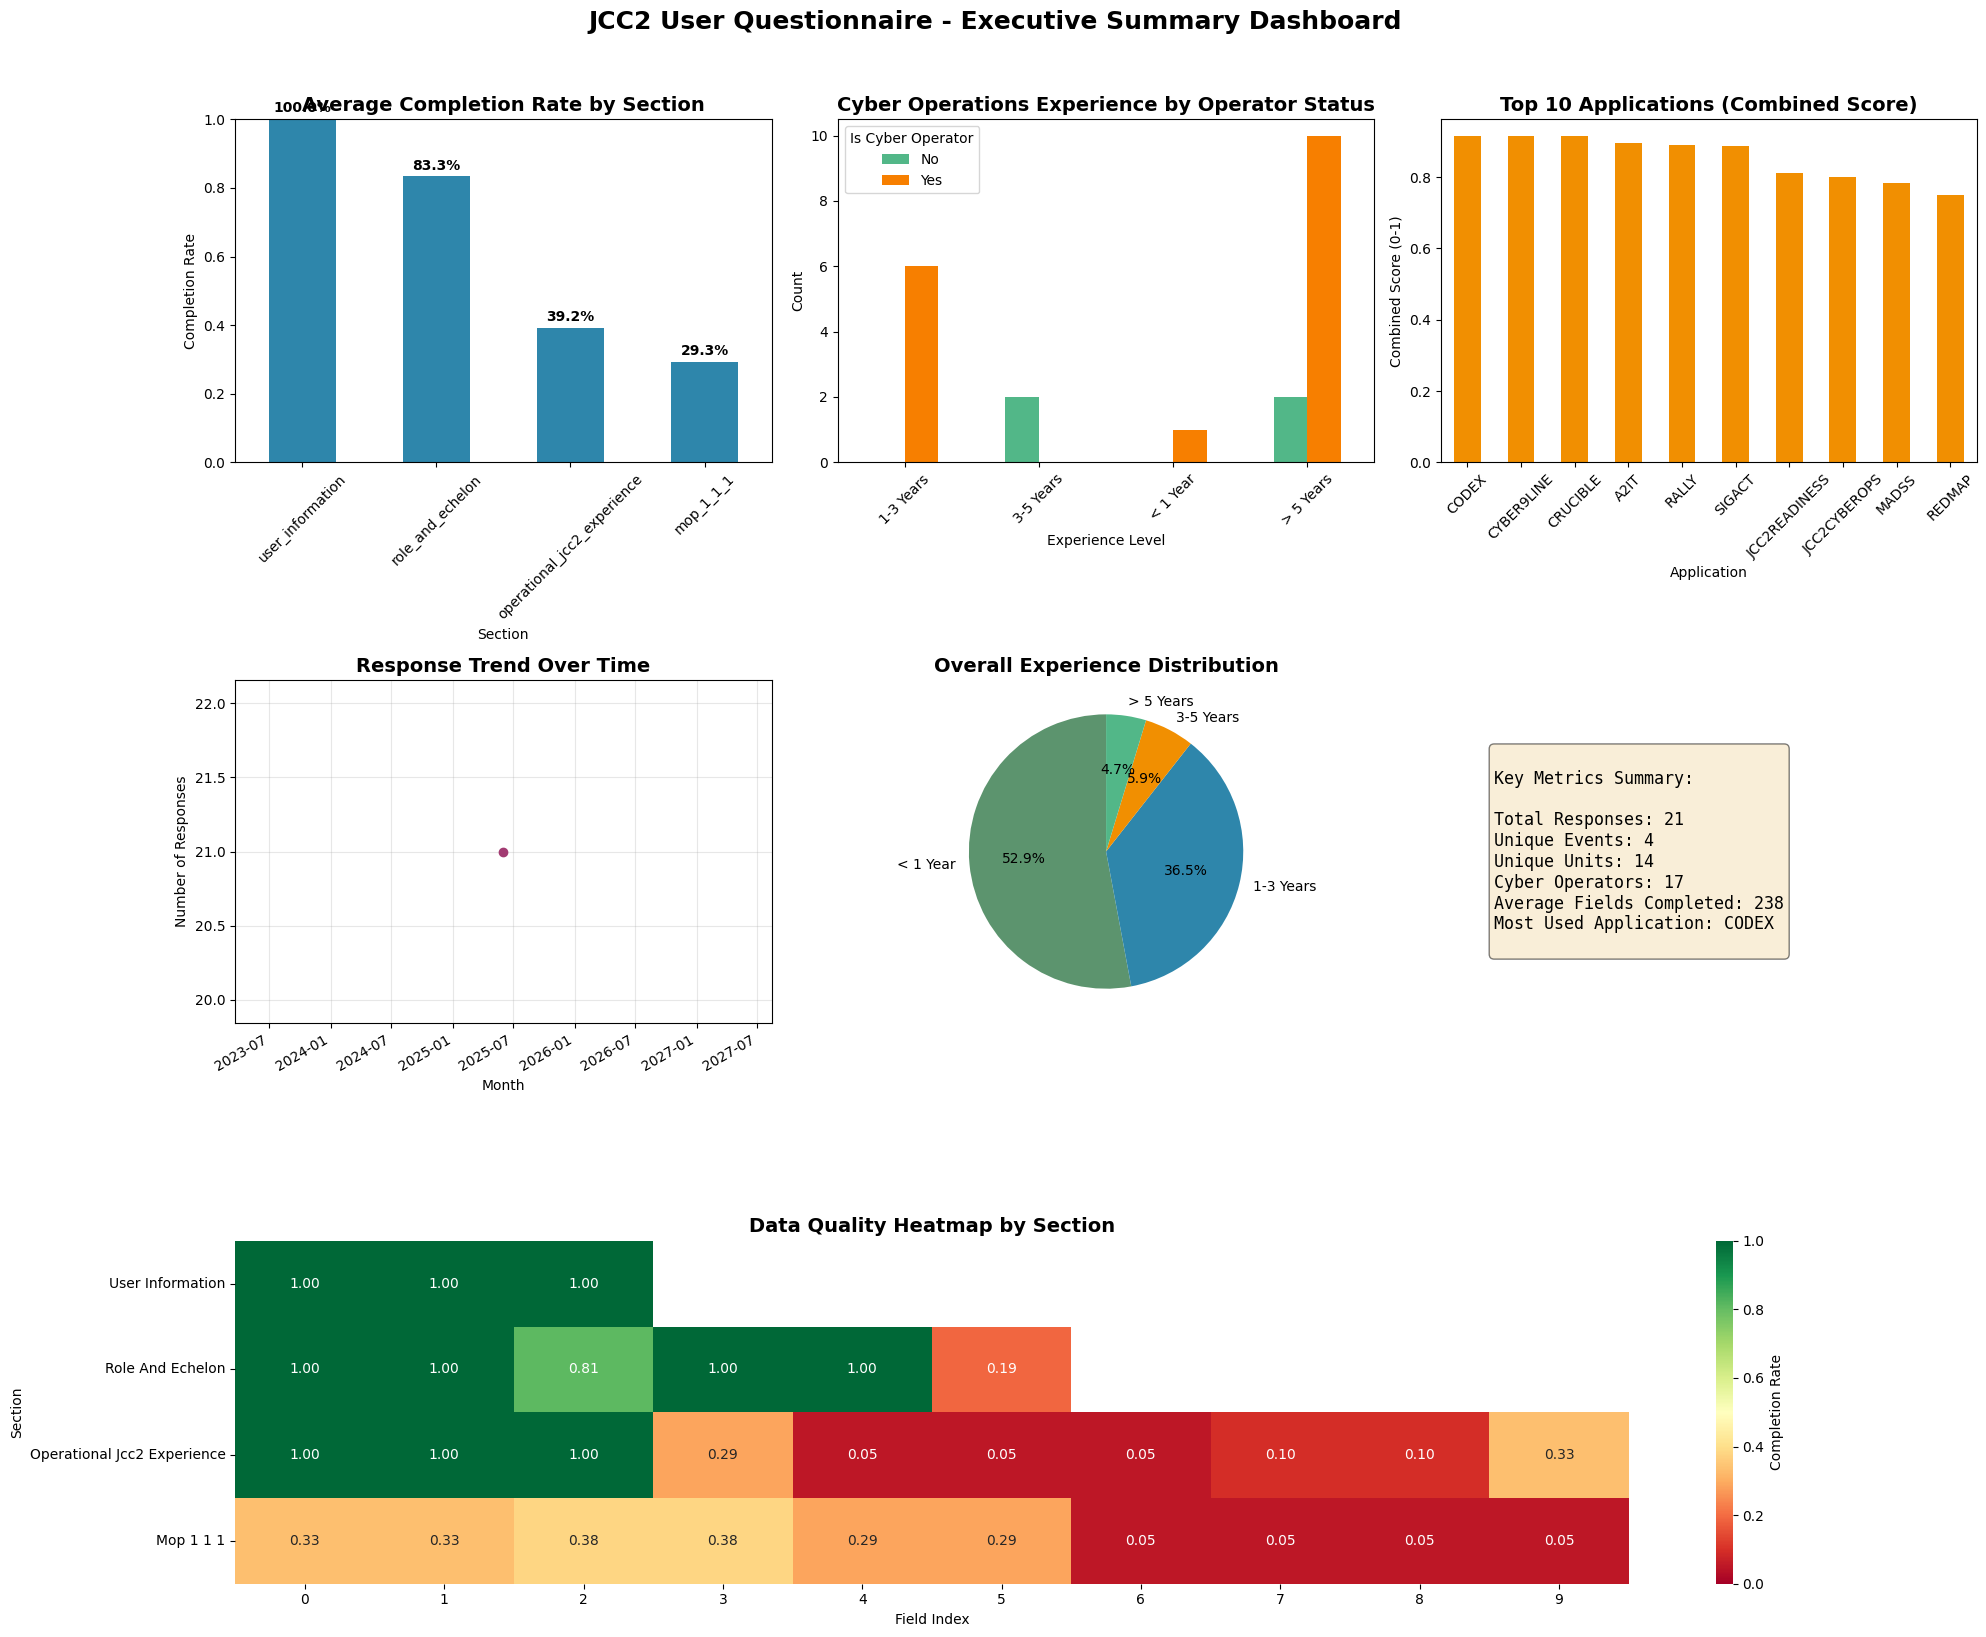

In [16]:
# Create a summary dashboard combining key insights from all sections
fig = plt.figure(figsize=(20, 16))

# 1. Section completion overview
ax1 = plt.subplot(3, 3, 1)
section_completion = {}
for section in sections_to_analyze:
    if section in processor.sections:
        fields = processor.sections[section]
        completion_rates = [df[field].notna().mean() for field in fields if field in df.columns]
        section_completion[section] = np.mean(completion_rates) if completion_rates else 0

comp_series = pd.Series(section_completion)
comp_series.plot(kind='bar', ax=ax1, color=COLORS['primary'])
ax1.set_title('Average Completion Rate by Section', fontsize=14, fontweight='bold')
ax1.set_xlabel('Section')
ax1.set_ylabel('Completion Rate')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)
for i, (section, rate) in enumerate(comp_series.items()):
    ax1.text(i, rate + 0.02, f'{rate:.1%}', ha='center', fontweight='bold')

# 2. Cyber operator distribution by experience
ax2 = plt.subplot(3, 3, 2)
if 'role_and_echelon.is_cyber_operator' in df.columns and 'operational_jcc2_experience.exp_cyberoperations' in df.columns:
    cyber_exp_cross = pd.crosstab(df['role_and_echelon.is_cyber_operator'],
                                  df['operational_jcc2_experience.exp_cyberoperations'])
    cyber_exp_cross.T.plot(kind='bar', ax=ax2, color=[COLORS['success'], COLORS['warning']])
    ax2.set_title('Cyber Operations Experience by Operator Status', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Experience Level')
    ax2.set_ylabel('Count')
    ax2.legend(title='Is Cyber Operator')
    ax2.tick_params(axis='x', rotation=45)

# 3. Top applications by usage and effectiveness
ax3 = plt.subplot(3, 3, 3)
# Combine adoption rate and effectiveness
app_scores = {}
for app in ['a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch', 
            'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap', 
            'sigact', 'threathub', 'triage', 'unity']:
    # Check experience field
    exp_field = f'operational_jcc2_experience.exp_app_{app}'
    intel_field = f'mop_1_1_1.intelligence_data_provided_{app}'
    
    adoption = 0
    effectiveness = 0
    
    if exp_field in df.columns:
        exp_counts = df[exp_field].value_counts()
        total = exp_counts.sum()
        na_count = exp_counts.get('NA', 0)
        if total > 0:
            adoption = (total - na_count) / total
    
    if intel_field in df.columns:
        ratings = df[intel_field].dropna()
        if len(ratings) > 0:
            numeric_ratings = ratings.map(effectiveness_map).fillna(0)
            effectiveness = numeric_ratings[numeric_ratings > 0].mean() / 6 if len(numeric_ratings[numeric_ratings > 0]) > 0 else 0
    
    if adoption > 0 or effectiveness > 0:
        app_scores[app.upper()] = (adoption + effectiveness) / 2

if app_scores:
    top_apps = pd.Series(app_scores).sort_values(ascending=False).head(10)
    top_apps.plot(kind='bar', ax=ax3, color=COLORS['tertiary'])
    ax3.set_title('Top 10 Applications (Combined Score)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Application')
    ax3.set_ylabel('Combined Score (0-1)')
    ax3.tick_params(axis='x', rotation=45)

# 4. Response distribution over time
ax4 = plt.subplot(3, 3, 4)
if 'user_information.date' in df.columns:
    df['month_year'] = pd.to_datetime(df['user_information.date']).dt.to_period('M')
    monthly_counts = df['month_year'].value_counts().sort_index()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    monthly_counts.plot(kind='line', ax=ax4, color=COLORS['secondary'], marker='o', linewidth=2)
    ax4.set_title('Response Trend Over Time', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Number of Responses')
    ax4.grid(True, alpha=0.3)

# 5. Experience level distribution summary
ax5 = plt.subplot(3, 3, 5)
exp_summary = {'< 1 Year': 0, '1-3 Years': 0, '3-5 Years': 0, '> 5 Years': 0}
exp_fields = [col for col in df.columns if 'operational_jcc2_experience.exp_app_' in col]
for field in exp_fields:
    counts = df[field].value_counts()
    for exp_level in exp_summary:
        exp_summary[exp_level] += counts.get(exp_level, 0)

exp_series = pd.Series(exp_summary)
exp_series.plot(kind='pie', ax=ax5, autopct='%1.1f%%', startangle=90, 
                colors=[COLORS['info'], COLORS['primary'], COLORS['tertiary'], COLORS['success']])
ax5.set_title('Overall Experience Distribution', fontsize=14, fontweight='bold')
ax5.set_ylabel('')

# 6. Key metrics summary
ax6 = plt.subplot(3, 3, 6)
ax6.axis('off')
metrics_text = f"""
Key Metrics Summary:

Total Responses: {len(df)}
Unique Events: {df['user_information.event'].nunique()}
Unique Units: {df['user_information.unit'].nunique()}
Cyber Operators: {(df['role_and_echelon.is_cyber_operator'] == 'Yes').sum()}
Average Fields Completed: {df.notna().sum(axis=1).mean():.0f}
Most Used Application: {top_apps.index[0] if len(top_apps) > 0 else 'N/A'}
"""
ax6.text(0.1, 0.5, metrics_text, transform=ax6.transAxes, fontsize=12, 
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 7. Data quality heatmap
ax7 = plt.subplot(3, 3, (7, 9))  # Span bottom row
quality_matrix = []
section_names = []
for section in sections_to_analyze:
    if section in processor.sections:
        section_names.append(section.replace('_', ' ').title())
        fields = processor.sections[section]
        row = []
        for field in fields[:10]:  # First 10 fields for readability
            if field in df.columns:
                row.append(df[field].notna().mean())
        quality_matrix.append(row)

if quality_matrix:
    quality_df = pd.DataFrame(quality_matrix, index=section_names)
    sns.heatmap(quality_df, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax7, 
                cbar_kws={'label': 'Completion Rate'}, vmin=0, vmax=1)
    ax7.set_title('Data Quality Heatmap by Section', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Field Index')
    ax7.set_ylabel('Section')

plt.suptitle('JCC2 User Questionnaire - Executive Summary Dashboard', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 7. Export Visualizations

In [17]:
# Function to save all visualizations
def save_all_visualizations():
    """
    Re-run all visualizations and save them as high-quality images
    """
    import os
    
    # Create output directory
    output_dir = 'jcc2_visualizations'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Saving visualizations to {output_dir}/...")
    
    # Note: In a real implementation, you would re-run each visualization
    # and save it using plt.savefig(). Here's an example structure:
    
    sections = [
        'user_information_analysis',
        'role_echelon_analysis', 
        'operational_experience_analysis',
        'mop_111_intelligence_analysis',
        'executive_summary_dashboard'
    ]
    
    print("\nTo save visualizations, re-run each section's code and add:")
    print("plt.savefig(f'{output_dir}/section_name.png', dpi=300, bbox_inches='tight')")
    print("\nVisualization sections ready for export:")
    for section in sections:
        print(f"  - {section}")

# Call the function
save_all_visualizations()

Saving visualizations to jcc2_visualizations/...

To save visualizations, re-run each section's code and add:
plt.savefig(f'{output_dir}/section_name.png', dpi=300, bbox_inches='tight')

Visualization sections ready for export:
  - user_information_analysis
  - role_echelon_analysis
  - operational_experience_analysis
  - mop_111_intelligence_analysis
  - executive_summary_dashboard


In [18]:
# Create analysis summary report
print("=" * 80)
print("JCC2 USER QUESTIONNAIRE ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nData Source: {csv_file}")
print(f"Total Responses Analyzed: {len(df)}")
print(f"Date Range: {df['user_information.date'].min()} to {df['user_information.date'].max()}")
print(f"\nSections Analyzed:")
for section in sections_to_analyze:
    if section in processor.sections:
        print(f"  ✓ {section}: {len(processor.sections[section])} fields")
print("\nKey Insights Generated:")
print("  • User demographics and participation patterns")
print("  • Role distribution and cyber operator analysis")
print("  • Application experience levels and adoption rates")
print("  • Intelligence data effectiveness ratings")
print("  • Cross-sectional quality and completion metrics")
print("\nVisualization Types Created:")
print("  • Bar charts, pie charts, and histograms")
print("  • Heatmaps and correlation matrices")
print("  • Time series and trend analyses")
print("  • Scatter plots and cross-tabulations")
print("  • Executive summary dashboard")
print("\n" + "=" * 80)

JCC2 USER QUESTIONNAIRE ANALYSIS COMPLETE

Data Source: /home/nathanjgaul/Downloads/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv
Total Responses Analyzed: 21
Date Range: 2025-06-23 00:00:00 to 2025-06-25 00:00:00

Sections Analyzed:
  ✓ user_information: 3 fields
  ✓ role_and_echelon: 6 fields
  ✓ operational_jcc2_experience: 18 fields
  ✓ mop_1_1_1: 31 fields

Key Insights Generated:
  • User demographics and participation patterns
  • Role distribution and cyber operator analysis
  • Application experience levels and adoption rates
  • Intelligence data effectiveness ratings
  • Cross-sectional quality and completion metrics

Visualization Types Created:
  • Bar charts, pie charts, and histograms
  • Heatmaps and correlation matrices
  • Time series and trend analyses
  • Scatter plots and cross-tabulations
  • Executive summary dashboard



# 8. Overall Data Quality & Response Summary


=== OVERALL DATA SUMMARY ===
                 Metric                                      Value
        Total Responses                                         21
           Total Fields                                        668
Average Completion Rate                                      35.6%
             Date Range 2025-06-23 00:00:00 to 2025-06-25 00:00:00
          Unique Events                                          4
           Unique Units                                         14


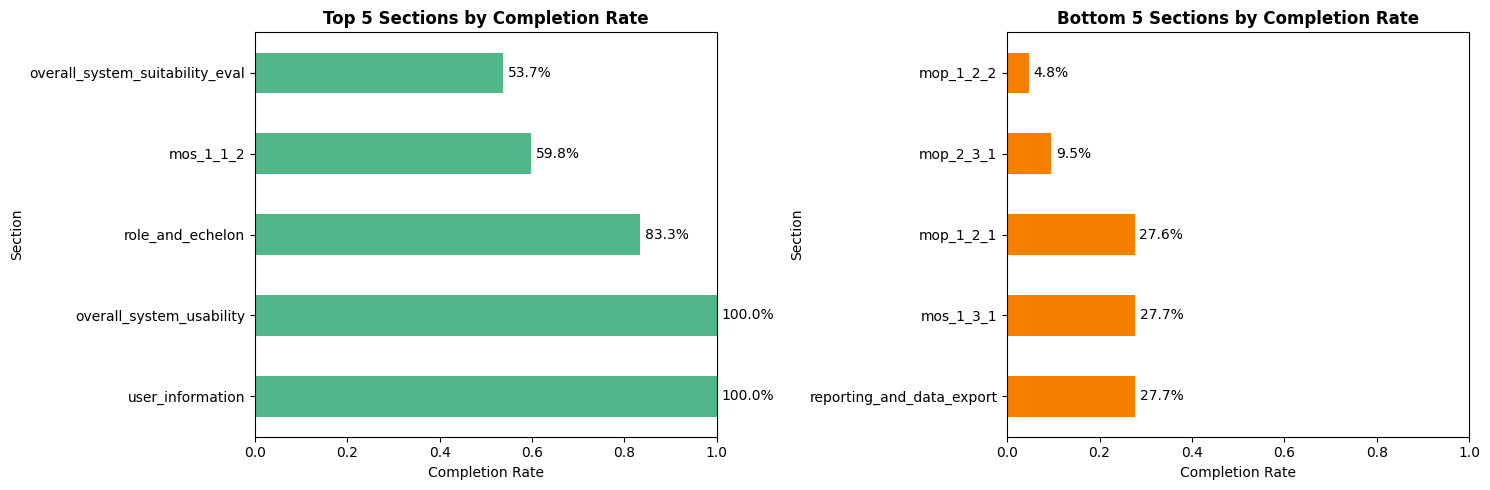

In [19]:
# Create overall metrics summary table
overall_metrics = []

# Basic statistics
overall_metrics.append(['Total Responses', len(df)])
overall_metrics.append(['Total Fields', len(df.columns)])
overall_metrics.append(['Average Completion Rate', f"{df.notna().sum().sum() / (len(df) * len(df.columns)) * 100:.1f}%"])
overall_metrics.append(['Date Range', f"{df['user_information.date'].min()} to {df['user_information.date'].max()}"])

# Participation metrics
if 'user_information.event' in df.columns:
    overall_metrics.append(['Unique Events', df['user_information.event'].nunique()])
if 'user_information.unit' in df.columns:
    overall_metrics.append(['Unique Units', df['user_information.unit'].nunique()])

# Create metrics table
metrics_df = pd.DataFrame(overall_metrics, columns=['Metric', 'Value'])
print("\n=== OVERALL DATA SUMMARY ===")
print(metrics_df.to_string(index=False))

# Quick visualization of response completion by section
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Section completion rates
section_completion = {}
for section_name, fields in processor.sections.items():
    completion_rates = [df[field].notna().mean() for field in fields if field in df.columns]
    if completion_rates:
        section_completion[section_name] = np.mean(completion_rates)

# Top and bottom 5 sections
sorted_sections = sorted(section_completion.items(), key=lambda x: x[1], reverse=True)
top_sections = sorted_sections[:5]
bottom_sections = sorted_sections[-5:]

# Plot top sections
top_df = pd.DataFrame(top_sections, columns=['Section', 'Completion'])
top_df.plot(x='Section', y='Completion', kind='barh', ax=ax1, color=COLORS['success'], legend=False)
ax1.set_title('Top 5 Sections by Completion Rate', fontweight='bold')
ax1.set_xlabel('Completion Rate')
ax1.set_xlim(0, 1)
for i, (_, rate) in enumerate(top_sections):
    ax1.text(rate + 0.01, i, f'{rate:.1%}', va='center')

# Plot bottom sections
bottom_df = pd.DataFrame(bottom_sections, columns=['Section', 'Completion'])
bottom_df.plot(x='Section', y='Completion', kind='barh', ax=ax2, color=COLORS['warning'], legend=False)
ax2.set_title('Bottom 5 Sections by Completion Rate', fontweight='bold')
ax2.set_xlabel('Completion Rate')
ax2.set_xlim(0, 1)
for i, (_, rate) in enumerate(bottom_sections):
    ax2.text(rate + 0.01, i, f'{rate:.1%}', va='center')

plt.tight_layout()
plt.show()

# 9. Section-by-Section Key Metrics

In [20]:
from collections import Counter 

# Define key metrics extractor for each section type
def extract_key_metrics(section_name, fields, df):
    """Extract the most important metrics for a given section."""
    metrics = {}
    
    # Common metrics for all sections
    valid_fields = [f for f in fields if f in df.columns]
    if valid_fields:
        completion_rates = [df[field].notna().mean() for field in valid_fields]
        metrics['Fields'] = len(valid_fields)
        metrics['Avg Completion'] = f"{np.mean(completion_rates):.1%}"
    
    # Section-specific metrics
    if section_name == 'user_information':
        if 'user_information.event' in df.columns:
            metrics['Events'] = df['user_information.event'].nunique()
        if 'user_information.unit' in df.columns:
            metrics['Units'] = df['user_information.unit'].nunique()
    
    elif section_name == 'role_and_echelon':
        if 'role_and_echelon.is_cyber_operator' in df.columns:
            cyber_pct = (df['role_and_echelon.is_cyber_operator'] == 'Yes').mean() * 100
            metrics['Cyber Operators'] = f"{cyber_pct:.1f}%"
        if 'role_and_echelon.echelon' in df.columns:
          # Flatten the list of lists into a single list of strings
          all_echelons = []
          for echelon_list in df['role_and_echelon.echelon']:
              if isinstance(echelon_list, list): # Make sure it's a list
                  all_echelons.extend(echelon_list)
              else:
                  #Handle cases that are not lists (NaN or single string)
                  if isinstance(echelon_list, str):
                      all_echelons.append(echelon_list) #Treat as a list of length 1.
                  else: #Handle None or NaN
                      all_echelons.append('N/A')

          # Count the occurrences of each echelon string
          echelon_counts = Counter(all_echelons)

          # Get the most frequent echelon
          if echelon_counts:  # Check if there are any echelons
              top_echelon = echelon_counts.most_common(1)[0][0]  # Get the most common string
          else:
              top_echelon = 'N/A'

          metrics['Top Echelon'] = top_echelon
    
    elif section_name == 'operational_jcc2_experience':
        exp_fields = [f for f in fields if 'exp_app_' in f and f in df.columns]
        if exp_fields:
            total_exp = 0
            for field in exp_fields:
                total_exp += (df[field] != 'NA').sum()
            metrics['App Experience'] = f"{total_exp / (len(exp_fields) * len(df)) * 100:.1f}%"
    
    elif section_name == 'jcc2_application_usage':
        freq_fields = [f for f in fields if 'frequency_' in f and f in df.columns]
        if freq_fields:
            daily_users = sum((df[f] == 'Daily').sum() for f in freq_fields)
            metrics['Daily Users'] = daily_users
        train_fields = [f for f in fields if 'training_received_' in f and f in df.columns]
        if train_fields:
            trained = sum((df[f] == 'Yes').sum() for f in train_fields)
            total = sum(df[f].notna().sum() for f in train_fields)
            metrics['Training Rate'] = f"{trained/total*100:.1f}%" if total > 0 else "0%"
    
    elif section_name.startswith('mop_'):
        eff_fields = [f for f in fields if 'effectiveness' in f and f in df.columns]
        if eff_fields:
            effectiveness_map = {'Completely Ineffective': 1, 'Ineffective': 2, 'Somewhat Ineffective': 3,
                               'Somewhat Effective': 4, 'Effective': 5, 'Completely Effective': 6}
            all_scores = []
            for field in eff_fields:
                scores = df[field].map(effectiveness_map).dropna()
                all_scores.extend(scores.tolist())
            if all_scores:
                metrics['Avg Effectiveness'] = f"{np.mean(all_scores):.2f}/6"
                metrics['% Effective'] = f"{(np.array(all_scores) >= 4).mean() * 100:.1f}%"
    
    elif section_name.startswith('mos_'):
        suit_fields = [f for f in fields if 'suitability' in f and f in df.columns]
        if suit_fields:
            suitability_map = {'Completely Unsuitable': 1, 'Unsuitable': 2, 'Somewhat Unsuitable': 3,
                             'Somewhat Suitable': 4, 'Suitable': 5, 'Completely Suitable': 6}
            all_scores = []
            for field in suit_fields:
                scores = df[field].map(suitability_map).dropna()
                all_scores.extend(scores.tolist())
            if all_scores:
                metrics['Avg Suitability'] = f"{np.mean(all_scores):.2f}/6"
                metrics['% Suitable'] = f"{(np.array(all_scores) >= 4).mean() * 100:.1f}%"
    
    elif section_name == 'overall_system_usability':
        sus_fields = [f for f in fields if f.startswith('overall_system_usability.sus_') and f in df.columns]
        if len(sus_fields) == 10:  # Complete SUS
            sus_scores = processor.calculate_sus_scores(df)
            if sus_scores:
                metrics['Avg SUS Score'] = f"{np.mean(sus_scores):.1f}"
                metrics['SUS Rating'] = 'Good' if np.mean(sus_scores) >= 68 else 'Poor'
    
    elif section_name == 'overall_system_suitability_eval':
        if 'overall_system_suitability_eval.recommend_jcc2' in df.columns:
            rec_counts = df['overall_system_suitability_eval.recommend_jcc2'].value_counts()
            yes_pct = rec_counts.get('Yes', 0) / rec_counts.sum() * 100 if rec_counts.sum() > 0 else 0
            metrics['Would Recommend'] = f"{yes_pct:.1f}%"
            
    return metrics

# Create comprehensive metrics table
section_metrics_data = []
priority_sections = [
    'user_information', 'role_and_echelon', 'operational_jcc2_experience',
    'jcc2_application_usage', 'mop_1_1_1', 'mos_1_1_2', 'reporting_and_data_export',
    'overall_system_usability', 'overall_system_suitability_eval'
]

for section in priority_sections:
    if section in processor.sections:
        metrics = extract_key_metrics(section, processor.sections[section], df)
        
        # Format section name
        display_name = section.replace('_', ' ').title()
        if section.startswith('mop_'):
            display_name = f"MOP {section.replace('mop_', '').replace('_', '.')}"
        elif section.startswith('mos_'):
            display_name = f"MOS {section.replace('mos_', '').replace('_', '.')}"
        
        # Create row with key metrics
        row = [display_name]
        for key in ['Fields', 'Avg Completion', 'Avg Effectiveness', 'Avg Suitability', 
                   'Avg SUS Score', 'Would Recommend', 'Cyber Operators', 'Daily Users']:
            row.append(metrics.get(key, '-'))
        
        section_metrics_data.append(row)

# Create DataFrame
columns = ['Section', 'Fields', 'Completion', 'Effectiveness', 'Suitability', 
          'SUS Score', 'Recommend', 'Cyber Ops', 'Daily Users']
section_metrics_df = pd.DataFrame(section_metrics_data, columns=columns)

print("\n=== SECTION-BY-SECTION KEY METRICS ===")
print(section_metrics_df.to_string(index=False))


=== SECTION-BY-SECTION KEY METRICS ===
                        Section  Fields Completion Effectiveness Suitability SUS Score Recommend Cyber Ops Daily Users
               User Information       3     100.0%             -           -         -         -         -           -
               Role And Echelon       6      83.3%             -           -         -         -     81.0%           -
    Operational Jcc2 Experience      18      39.2%             -           -         -         -         -           -
         Jcc2 Application Usage      60      39.9%             -           -         -         -         -          25
                      MOP 1.1.1      31      29.3%        4.75/6           -         -         -         -           -
                      MOS 1.1.2       9      59.8%             -           -         -         -         -           -
      Reporting And Data Export     106      27.7%             -           -         -         -         -           -
       O

AttributeError: 'UserQuestionnaireProcessor' object has no attribute 'calculate_nps_score'

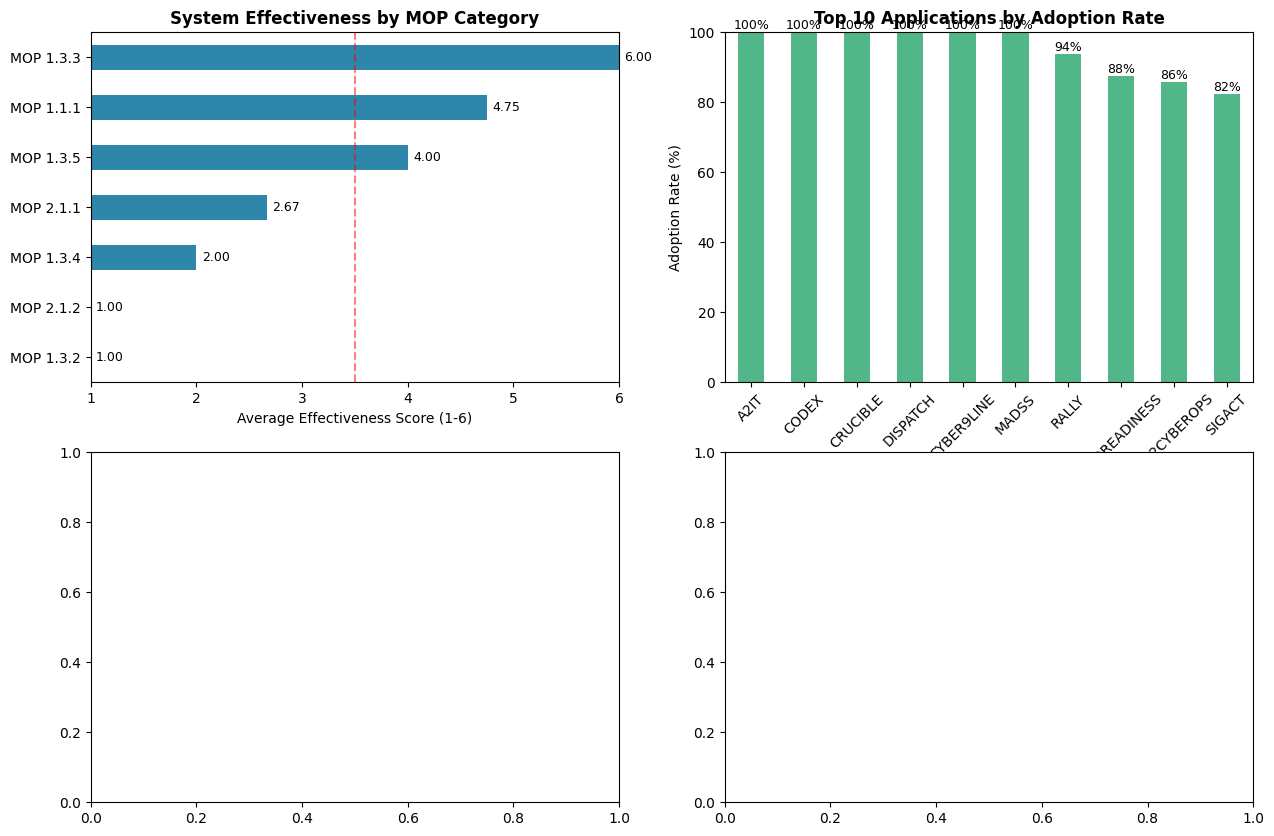

In [21]:
# Create a 2x2 dashboard with the most critical insights
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. System Effectiveness Overview (MOP scores)
mop_scores = {}
effectiveness_map = {'Completely Ineffective': 1, 'Ineffective': 2, 'Somewhat Ineffective': 3,
                    'Somewhat Effective': 4, 'Effective': 5, 'Completely Effective': 6}

for section in processor.sections:
    if section.startswith('mop_'):
        eff_fields = [f for f in processor.sections[section] if 'effectiveness' in f and f in df.columns]
        if eff_fields:
            all_scores = []
            for field in eff_fields:
                scores = df[field].map(effectiveness_map).dropna()
                all_scores.extend(scores.tolist())
            if all_scores:
                section_label = f"MOP {section.replace('mop_', '').replace('_', '.')}"
                mop_scores[section_label] = np.mean(all_scores)

if mop_scores:
    mop_series = pd.Series(mop_scores).sort_values()
    mop_series.plot(kind='barh', ax=ax1, color=COLORS['primary'])
    ax1.set_title('System Effectiveness by MOP Category', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Average Effectiveness Score (1-6)')
    ax1.axvline(3.5, color='red', linestyle='--', alpha=0.5, label='Neutral')
    ax1.set_xlim(1, 6)
    for i, (cat, score) in enumerate(mop_series.items()):
        ax1.text(score + 0.05, i, f'{score:.2f}', va='center', fontsize=9)

# 2. Application Adoption Rate (Top 10)
app_adoption = {}
apps = ['a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch', 
        'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap', 
        'sigact', 'threathub', 'triage', 'unity']

for app in apps:
    freq_field = f'jcc2_application_usage.frequency_{app}'
    if freq_field in df.columns:
        total = df[freq_field].notna().sum()
        never = (df[freq_field] == 'Never').sum()
        if total > 0:
            adoption = (total - never) / total * 100
            app_adoption[app.upper()] = adoption

if app_adoption:
    top_apps = pd.Series(app_adoption).sort_values(ascending=False).head(10)
    top_apps.plot(kind='bar', ax=ax2, color=COLORS['success'])
    ax2.set_title('Top 10 Applications by Adoption Rate', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Adoption Rate (%)')
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='x', rotation=45)
    for i, (app, rate) in enumerate(top_apps.items()):
        ax2.text(i, rate + 1, f'{rate:.0f}%', ha='center', fontsize=9)

# 3. Overall System Evaluation Metrics
eval_metrics = {}

# SUS Score
sus_fields = [f for f in df.columns if f.startswith('overall_system_usability.sus_')]
if len(sus_fields) == 10:
    sus_scores = processor.calculate_sus_scores(df)
    if sus_scores:
        eval_metrics['SUS Score'] = np.mean(sus_scores)

# NPS Score
nps_scores = processor.calculate_nps_score(df)
if nps_scores is not None:
    eval_metrics['NPS'] = nps_scores + 50  # Shift to 0-100 scale

# Recommendation Rate
if 'overall_system_suitability_eval.recommend_jcc2' in df.columns:
    rec_counts = df['overall_system_suitability_eval.recommend_jcc2'].value_counts()
    if rec_counts.sum() > 0:
        eval_metrics['Would Recommend'] = rec_counts.get('Yes', 0) / rec_counts.sum() * 100

# Overall Effectiveness
if 'reporting_and_data_export.overall_reporting_effectiveness' in df.columns:
    eff_counts = df['reporting_and_data_export.overall_reporting_effectiveness'].map(effectiveness_map).dropna()
    if len(eff_counts) > 0:
        eval_metrics['Reporting Effectiveness'] = (eff_counts >= 4).mean() * 100

if eval_metrics:
    eval_series = pd.Series(eval_metrics)
    colors = [COLORS['success'] if v >= 70 else COLORS['warning'] if v >= 50 else COLORS['danger'] 
             for v in eval_series.values]
    
    eval_series.plot(kind='bar', ax=ax3, color=colors)
    ax3.set_title('Overall System Evaluation Metrics', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Score / Percentage')
    ax3.set_ylim(0, 100)
    ax3.axhline(70, color='green', linestyle='--', alpha=0.5, label='Good')
    ax3.axhline(50, color='orange', linestyle='--', alpha=0.5, label='Acceptable')
    ax3.tick_params(axis='x', rotation=45)
    
    for i, (metric, value) in enumerate(eval_series.items()):
        ax3.text(i, value + 1, f'{value:.0f}', ha='center', fontsize=9)

# 4. Training vs Usage Correlation Summary
training_usage_data = []
for app in apps[:8]:  # Top 8 apps for clarity
    freq_field = f'jcc2_application_usage.frequency_{app}'
    train_field = f'jcc2_application_usage.training_received_{app}'
    
    if freq_field in df.columns and train_field in df.columns:
        # Usage intensity (Never=0, Monthly=1, Weekly=2, Daily=3)
        usage_map = {'Never': 0, 'Monthly': 1, 'Weekly': 2, 'Daily': 3}
        avg_usage = df[freq_field].map(usage_map).mean()
        
        # Training percentage
        train_pct = (df[train_field] == 'Yes').mean() * 100
        
        if pd.notna(avg_usage) and pd.notna(train_pct):
            training_usage_data.append({
                'app': app.upper(),
                'usage': avg_usage,
                'training': train_pct
            })

if training_usage_data:
    tu_df = pd.DataFrame(training_usage_data)
    scatter = ax4.scatter(tu_df['training'], tu_df['usage'], 
                         s=100, alpha=0.6, color=COLORS['info'])
    
    for _, row in tu_df.iterrows():
        ax4.annotate(row['app'], (row['training'], row['usage']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add trend line
    z = np.polyfit(tu_df['training'], tu_df['usage'], 1)
    p = np.poly1d(z)
    ax4.plot(tu_df['training'].sort_values(), p(tu_df['training'].sort_values()), 
            "r--", alpha=0.5, label=f'Trend: {z[0]:.3f}x + {z[1]:.2f}')
    
    ax4.set_xlabel('Users Trained (%)')
    ax4.set_ylabel('Average Usage Intensity (0-3)')
    ax4.set_title('Training vs Usage Correlation', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    ax4.set_xlim(-5, 105)
    ax4.set_ylim(-0.2, 3.2)

plt.suptitle('JCC2 Critical Insights Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()